<a href="https://colab.research.google.com/github/evillag/uncertainty_gan/blob/main/TestBench.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install tf_keras pandas scipy tqdm scikit-learn matplotlib

Once the celd finished click on restart sesion.

In [1]:
output_dir = 'results'
run_date = '2024-nov-25'

!mkdir {output_dir}
!mkdir {output_dir}/{run_date}
output_dir = f'{output_dir}/{run_date}'

mkdir: cannot create directory ‘results’: File exists


In [ ]:
%rm -rf experiments
%rm -rf src
%rm -rf lhcb-rich-gan-uncertainty-conare/
!git clone https://gitlab.com/evillag/lhcb-rich-gan-uncertainty-conare.git
!mv lhcb-rich-gan-uncertainty-conare/experiments .
!mv lhcb-rich-gan-uncertainty-conare/src .
%rm -rf lhcb-rich-gan-uncertainty-conare/
%rm -rf sample_data/

In [ ]:
# dataset downloading and extraction
# !wget --show-progress -O rich.zip https://www.dropbox.com/scl/fi/vy885v97hvgirtwtbk8r6/rich.zip?rlkey=zwg284rv7q0lrr9z1pk88g5yx&st=1s4wciep&dl=0
# !unzip -qq rich.zip
# !rm rich.zip

# # checkpoints2
# !wget --show-progress -O checkpoints.zip https://www.dropbox.com/scl/fi/466pwb9aoizlxdrcwmu2p/checkpoints_dropout_0.01.zip?rlkey=eqx2c82md4qber0nilii3drq4&st=6m5qqjgg&dl=0
# !unzip -qq checkpoints.zip
# !rm checkpoints.zip
# 
# # embeddings
# !wget --show-progress -O embeddings.zip https://www.dropbox.com/scl/fi/qjwk4u5i55603zwubqbjw/embeddings.zip?rlkey=7ucyd46sa11nplaen0qz47cd4&st=8upo51x9&dl=0
# !unzip -qq embeddings.zip
# !rm embeddings.zip


# Imports

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import time

from feature_densities.feature_density_evaluator import evaluate_model as fd_evaluate_model
from feature_densities.feature_density_evaluator import create_embeddings_model
from feature_densities.feature_density_evaluator import get_histogram
from mcd.MCDEvaluator import evaluate_model as mcd_evaluate_model
from test_bench import get_checkpoint_name, load_particle_datasets, subsample_dataset
from test_bench.model import MonteCarloDropoutModel
from tqdm import trange


tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
# Instruct tf to use the GPU memory efficiently
for gpu in tf.config.list_physical_devices("GPU"):
    tf.config.experimental.set_memory_growth(gpu, True)

print(f'GPU available? {tf.config.list_physical_devices("GPU")}')

2024-11-28 12:40:00.175815: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732819200.196103   66877 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732819200.200006   66877 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-28 12:40:00.220380: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


GPU available? [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Test Bench for the Monte Carlo Dropout and Feature Density methods

1. Select sample data
2. Create a model
3. Generate a single target with single inference mode
4. Estimate MCD uncertainty
5. Estimate FD uncertainty

## Experiment Params

In [4]:
# Parameters
PARTICLE = 'pion'
MCD_DP = 0.1
CHECKPOINT_DP = 0.01
DROPOUT_TYPE = 'bernoulli_structured'
CHECKPOINT_BASE = 'checkpoints/'
DATA_DIR = 'data/rich/'
SUB_SAMPLE_SIZE = 100000
DLL_COLUMNS = ['RichDLLe', 'RichDLLK', 'RichDLLmu', 'RichDLLp', 'RichDLLbt']

# Experiment repetitions
N = 30

# MCD parameters
MCD_ENSEMBLE_SIZE = 300

# FD parameters
embeddings_dir = f'embeddings/'

# Load previous results (Optional)

Uncomment to load previous execution results.

In [5]:
# output_dir = f'/content/drive/MyDrive/cern/data/results/'

# x_sample = np.load(output_dir + f'{PARTICLE}_x_real.npy')
# y_sample = np.load(output_dir + f'{PARTICLE}_y_real.npy')
# t_generated = np.load(output_dir + f'{PARTICLE}_t_generated.npy')

# mcd_uncertainty = np.load(output_dir + f'{PARTICLE}_mcd_uncertainty.npy')
# fd_uncertainty_normalized = np.load(output_dir + f'{PARTICLE}_fd_uncertainty_normalized.npy')
# #fd_uncertainty_integration = np.load(output_dir + f'{PARTICLE}_fd_uncertainty_integration.npy')

# Load data and Sample selection

In [6]:
dataset = load_particle_datasets(PARTICLE, DATA_DIR)

Reading and concatenating datasets:
	data/rich/pion_+_down_2016_.csv
	data/rich/pion_-_down_2016_.csv
	data/rich/pion2_+_down_2016_.csv
	data/rich/pion2_+_up_2016_.csv
	data/rich/pion2_-_up_2016_.csv
	data/rich/pion2_-_down_2016_.csv
	data/rich/pion_+_up_2016_.csv
	data/rich/pion_-_up_2016_.csv
splitting to train/val/test
fitting the scaler
scaler train sample size: 2000000
scaler n_quantiles: 100000, time = 1.3136959075927734
scaling train set
scaling test set
converting dtype to <class 'numpy.float32'>
feats_train shape	(948429, 3)
targets_train shape	(948429, 5)
feats_val shape  	(525947, 3)
targets_val shape	(525947, 5)
feats_train_orig shape	(948429, 3)
targets_train_orig shape	(948429, 5)
feats_val_orig shape  	(525947, 3)
targets_val_orig shape	(525947, 5)



In [7]:
# Draw a sample of the datasets
x_sample, y_sample, x_sample_orig, y_sample_orig = subsample_dataset(dataset['feats_val'], dataset['targets_val'], dataset['feats_val_orig'],  dataset['targets_val_orig'] , SUB_SAMPLE_SIZE / dataset['feats_val'].shape[0])
x_sample.shape, y_sample.shape,  x_sample_orig.shape, y_sample_orig.shape

I0000 00:00:1732819234.807625   66877 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9527 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070, pci bus id: 0000:2e:00.0, compute capability: 8.9


(TensorShape([100000, 3]),
 TensorShape([100000, 5]),
 TensorShape([100000, 3]),
 TensorShape([100000, 5]))

# Model creation

In [8]:
model = MonteCarloDropoutModel(
    PARTICLE,
    dropout_rate=MCD_DP,
    checkpoint_dir=CHECKPOINT_BASE + get_checkpoint_name(PARTICLE, CHECKPOINT_DP, DROPOUT_TYPE),
    debug=True
)
generator = model.get_generator()

Generating model for pion with a dropout rate of 0.1
Layer 0
Layer 1
Layer 2
Layer 3
Layer 4

Generator:

Model: "virtual_ensemble_model"
________________________________________________________________________________________________
 Layer (type)                              Output Shape                          Param #        
 Inputs (InputLayer)                       [(None, 3)]                           0              
                                                                                                
 NoiseInjection (NoiseInjection)           (None, 67)                            0              
                                                                                                
 Layer_0_Dense (Dense)                     (None, 128)                           8704           
                                                                                                
 Layer_0_LeakyReLU (LeakyReLU)             (None, 128)                           0    

## Single model prediction

In [9]:
generator.single_model_inference_mode()
t_generated = generator.predict(x_sample)
t_generated.shape

I0000 00:00:1732819235.482547   67073 cuda_dnn.cc:529] Loaded cuDNN version 90300


3125/3125 [==============================] - 5s 1ms/step


(100000, 5)

In [10]:
# Save real and generated targets
np.save(output_dir + f'{PARTICLE}_x_real.npy', x_sample)
np.save(output_dir + f'{PARTICLE}_y_real.npy', y_sample)
np.save(output_dir + f'{PARTICLE}_t_generated.npy', t_generated)

### Plotting functions

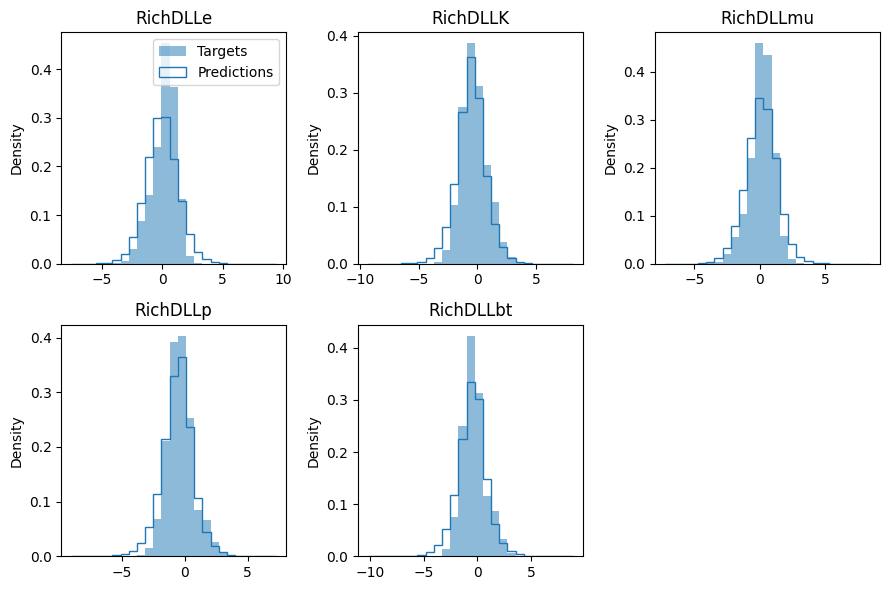

In [11]:
def plot_target_histrogams(real_targets, generated_targets, dll_columns=DLL_COLUMNS):
  fig, axes = plt.subplots(2, 3, figsize=(9, 6))

  for i, ax in enumerate(axes.flatten()[:-1]):
    particle_targets = np.array(real_targets[:, i])
    particle_predictions = np.array(generated_targets[:, i])

    mins = particle_targets.min(), particle_predictions.min()
    maxs = particle_targets.max(), particle_predictions.max()

    hist_range = min(mins), max(maxs)

    ax.set_title(dll_columns[i])
    ax.hist(particle_targets, 25, hist_range, True, alpha=.5, label='Targets')
    ax.hist(particle_predictions, 25, hist_range, True, histtype='step', color='tab:blue', label='Predictions')
    ax.set_ylabel('Density')

  axes[0, 0].legend()
  axes[-1, -1].axis(False)
  plt.tight_layout()
  plt.show()

plot_target_histrogams(y_sample, t_generated)

In [12]:
from scipy.spatial.distance import jensenshannon
from scipy.stats import linregress, kstest

def estimate_distances_and_plot_uncertainty_bins(y_real, y_generated, uncertainty_scores, uncertainty_type = None, bin_type = 'quantiles',
                                                 particle_index = 0, metric = 'JS', n_rows = 2, n_cols = 5, dll_columns=DLL_COLUMNS):
  n_bins = n_rows * n_cols

  targets = np.array(y_real[:, particle_index])
  predictions = np.array(y_generated[:, particle_index])
  uncertainty_scores = np.array(uncertainty_scores)

  if uncertainty_type == 'MCD':
    uncertainty_scores = uncertainty_scores[:, particle_index]

  if bin_type == 'linear':
    bin_edges = np.linspace(uncertainty_scores.min(), uncertainty_scores.max(), n_bins + 1)
  else: # Quantiles
    bin_edges = np.quantile(uncertainty_scores, np.linspace(0, 1, n_bins + 1))

  # Digitize returns sample indices per bin
  bin_indices = np.digitize(uncertainty_scores, bin_edges)

  fig, axes = plt.subplots(n_rows, n_cols, figsize=(3 * n_cols, 3 * n_rows))

  rounded_bin_edges = np.round(bin_edges, 3)

  distances = []

  for i, ax in enumerate(axes.flatten()):
    indices = bin_indices == i + 1

    mins = targets[indices].min(), predictions[indices].min()
    maxs = targets[indices].max(), predictions[indices].max()

    hist_range = min(mins), max(maxs)

    targets_hist = ax.hist(targets[indices], 25, hist_range, True, alpha=.5, label='Targets')[0]
    predictions_hist = ax.hist(
        predictions[indices], 25, hist_range, True, histtype='step', color='tab:blue', label='Predictions')[0]

    ax.set_title(f'{rounded_bin_edges[i]} < unc. score < {rounded_bin_edges[i + 1]}')
    ax.set_ylabel('Density')
    ax.set_xlabel(f'{dll_columns[particle_index]}')


    if metric == 'JS':
      dist = jensenshannon(predictions_hist, targets_hist)
    else:
      dist = kstest(predictions[indices], targets[indices]).statistic

    distances += [dist]
    print(f'{rounded_bin_edges[i]} < unc. score < {rounded_bin_edges[i + 1]}: Number of observations: {len(predictions[indices])}')

  plt.suptitle(f'{uncertainty_type} uncertainty score bins for {dll_columns[particle_index]}')
  axes[0, 0].legend()
  plt.tight_layout()
  try:
    TIKZ
    tikzplotlib.save(f'{uncertainty_type}_uncertainty_score_bins_for_{dll_columns[particle_index]}.tex')
  except:
    plt.show()
  print(f"{metric} Distances:\n" + ", ".join([str(dist) for dist in distances]))

  return bin_edges, distances


def plot_distances(bin_ranges, distances, uncertainty_type, dll_columns=DLL_COLUMNS, particle_index = 0):
  bin_ranges = np.mean([bin_ranges[1:], bin_ranges[:-1]], 0)

  plt.title(f'{uncertainty_type} reliability curve for {dll_columns[particle_index]}')
  plt.gca().set_axisbelow(True)
  plt.grid()
  plt.plot(bin_ranges, distances, '.-')
  plt.xlabel('Uncertainty score')
  plt.ylabel('Jensen–Shannon distance')
  plt.show()

  print('Correlation coefficient:', linregress(bin_ranges, distances).rvalue)

def plot_all_distances(all_bin_ranges, all_distances, uncertainty_type, dll_columns=DLL_COLUMNS, particle_index = 0, metric='JS'):
  plt.figure()
  plt.title(f'{uncertainty_type} reliability curves')
  plt.gca().set_axisbelow(True)
  plt.grid()

  correlation_coefficient = []
  for i in range(5):
    bin_ranges = np.mean([all_bin_ranges[i][1:], all_bin_ranges[i][:-1]], 0)
    plt.plot(bin_ranges, all_distances[i], '.-', label=dll_columns[i])
    regress = linregress(bin_ranges, all_distances[i])
    correlation_coefficient += [regress.rvalue]
    print(f'Correlation coefficient for {dll_columns[i]}:', regress.rvalue)

  plt.xlabel('Uncertainty score')
  if metric == 'JS':
    plt.ylabel('Jensen–Shannon distance')
  else:
    plt.ylabel('Kolmogorov-Smirnov distance')
  plt.legend()

  try:
    TIKZ
    tikzplotlib.save(f'{uncertainty_type}_reliability_curves_{metric}.tex')
  except:
    plt.show()


## Monte Carlo Dropout method

## Uncertainty estimation

In [13]:
def mcd_uncertainties_experiment(repetitions=N, mode='ensemble_inference'):
  # MCD ensemble mode
  mcd_ensemble_uncertainties = []
  mcd_duration = []

  for i in trange(repetitions):
    # print(f'MCD ensemble mode Run {i + 1} of {repetitions}')
    start_time = time.time()
    mcd_unc = mcd_evaluate_model(model, x_sample, MCD_ENSEMBLE_SIZE, mode=mode)[0]
    end_time = time.time()    
    mcd_ensemble_uncertainties.append(mcd_unc)
    mcd_duration.append(end_time - start_time)
    # print(f"Elapsed time: {mcd_duration[-1]} seconds")

  stacked_mcd_ensemble = tf.stack(mcd_ensemble_uncertainties)
  average_mcd_ensemble = tf.reduce_mean(stacked_mcd_ensemble, axis=0)

  return average_mcd_ensemble, stacked_mcd_ensemble, mcd_duration

def mcd_global_experiment(global_repetitions=N):
  mcd_all_uncertainties = []
  mcd_all_durations = []
  
  for i in range(global_repetitions):
    print(f'MCD Experiment Run {i + 1} of {global_repetitions}')
    average_mcd_ensemble, _, mcd_durations = mcd_uncertainties_experiment()
    average_mcd_single, _, _ = mcd_uncertainties_experiment(mode='single')

    mcd_final_uncertainty = np.abs(average_mcd_ensemble - average_mcd_single)    
    mcd_all_uncertainties.append(mcd_final_uncertainty)
    mcd_all_durations.append(mcd_durations)

  return mcd_all_uncertainties, mcd_all_durations


In [14]:
mcd_all_uncertainties, mcd_all_durations = mcd_global_experiment(N)
mcd_final_uncertainty = tf.reduce_mean(mcd_all_uncertainties, axis=0)

MCD Experiment Run 1 of 30


100%|██████████| 30/30 [00:52<00:00,  1.75s/it]


MCD Experiment Run 2 of 30


100%|██████████| 30/30 [00:52<00:00,  1.73s/it]


MCD Experiment Run 3 of 30


100%|██████████| 30/30 [00:49<00:00,  1.63s/it]


MCD Experiment Run 4 of 30


100%|██████████| 30/30 [00:48<00:00,  1.63s/it]


MCD Experiment Run 5 of 30


100%|██████████| 30/30 [00:49<00:00,  1.64s/it]


MCD Experiment Run 6 of 30


100%|██████████| 30/30 [00:49<00:00,  1.63s/it]


MCD Experiment Run 7 of 30


100%|██████████| 30/30 [00:48<00:00,  1.63s/it]


MCD Experiment Run 8 of 30


100%|██████████| 30/30 [00:49<00:00,  1.64s/it]


MCD Experiment Run 9 of 30


100%|██████████| 30/30 [00:48<00:00,  1.63s/it]


MCD Experiment Run 10 of 30


100%|██████████| 30/30 [00:48<00:00,  1.63s/it]


MCD Experiment Run 11 of 30


100%|██████████| 30/30 [00:49<00:00,  1.63s/it]


MCD Experiment Run 12 of 30


100%|██████████| 30/30 [00:49<00:00,  1.64s/it]


MCD Experiment Run 13 of 30


100%|██████████| 30/30 [00:48<00:00,  1.63s/it]


MCD Experiment Run 14 of 30


100%|██████████| 30/30 [00:49<00:00,  1.63s/it]


MCD Experiment Run 15 of 30


100%|██████████| 30/30 [00:52<00:00,  1.75s/it]


MCD Experiment Run 16 of 30


100%|██████████| 30/30 [00:52<00:00,  1.75s/it]


MCD Experiment Run 17 of 30


100%|██████████| 30/30 [00:52<00:00,  1.74s/it]


MCD Experiment Run 18 of 30


100%|██████████| 30/30 [00:52<00:00,  1.75s/it]


MCD Experiment Run 19 of 30


100%|██████████| 30/30 [00:52<00:00,  1.77s/it]


MCD Experiment Run 20 of 30


100%|██████████| 30/30 [00:52<00:00,  1.75s/it]


MCD Experiment Run 21 of 30


100%|██████████| 30/30 [00:52<00:00,  1.76s/it]


MCD Experiment Run 22 of 30


100%|██████████| 30/30 [00:52<00:00,  1.75s/it]


MCD Experiment Run 23 of 30


100%|██████████| 30/30 [00:52<00:00,  1.76s/it]


MCD Experiment Run 24 of 30


100%|██████████| 30/30 [00:52<00:00,  1.75s/it]


MCD Experiment Run 25 of 30


100%|██████████| 30/30 [00:53<00:00,  1.78s/it]


MCD Experiment Run 26 of 30


100%|██████████| 30/30 [00:49<00:00,  1.64s/it]


MCD Experiment Run 27 of 30


100%|██████████| 30/30 [00:48<00:00,  1.63s/it]


MCD Experiment Run 28 of 30


100%|██████████| 30/30 [00:52<00:00,  1.75s/it]


MCD Experiment Run 29 of 30


100%|██████████| 30/30 [00:53<00:00,  1.78s/it]


MCD Experiment Run 30 of 30


100%|██████████| 30/30 [00:52<00:00,  1.77s/it]


In [16]:
# Save MCD duration
mcd_avg_duration = np.mean(mcd_all_durations)
mcd_std_duration = np.std(mcd_all_durations)
print(f"MCD Average duration:\t{mcd_avg_duration} seconds")
print(f"MCD Std duration:\t\t{mcd_std_duration} seconds")
np.save(f'{output_dir}/{PARTICLE}_mcd_duration_list.npy', mcd_all_durations)

# Save MCD uncertainties
np.save(f'{output_dir}/{PARTICLE}_mcd_uncertainty.npy', mcd_all_uncertainties)


MCD Average duration:	3.705864669481913 seconds
MCD Std duration:		0.07879676004062854 seconds


In [27]:
print(mcd_all_durations)
print(len(mcd_all_uncertainties))
print(len(mcd_all_uncertainties[0]))
print(mcd_final_uncertainty.shape)

[[4.2885355949401855, 3.8616580963134766, 3.853517532348633, 3.706713914871216, 3.7057793140411377, 3.8063242435455322, 3.807241678237915, 3.691995143890381, 3.9106554985046387, 3.7749862670898438, 3.8333020210266113, 3.8637888431549072, 3.7513277530670166, 3.8567023277282715, 3.8667125701904297, 3.848893404006958, 3.6976144313812256, 3.660078525543213, 3.6583476066589355, 3.746799945831299, 3.6604859828948975, 3.7711822986602783, 3.8359248638153076, 3.728325366973877, 3.6595258712768555, 3.660501480102539, 3.6649913787841797, 3.709174871444702, 3.656362533569336, 3.6534783840179443], [3.650486469268799, 3.6356618404388428, 3.6423065662384033, 3.637770414352417, 3.7243711948394775, 3.811673402786255, 3.639673948287964, 3.754620313644409, 3.769083023071289, 3.626805543899536, 3.65981388092041, 3.646080732345581, 3.7941482067108154, 3.7354249954223633, 3.652944803237915, 3.6916210651397705, 3.625931739807129, 3.6217122077941895, 3.676453113555908, 3.701685905456543, 3.630099058151245, 3.

### Plot MCD uncertainties

#### JS / Quantile bins

0.247 < unc. score < 0.323: Number of observations: 10000
0.323 < unc. score < 0.36: Number of observations: 10000
0.36 < unc. score < 0.397: Number of observations: 10000
0.397 < unc. score < 0.437: Number of observations: 10000
0.437 < unc. score < 0.48: Number of observations: 10000
0.48 < unc. score < 0.534: Number of observations: 10000
0.534 < unc. score < 0.601: Number of observations: 10000
0.601 < unc. score < 0.691: Number of observations: 10000
0.691 < unc. score < 0.84: Number of observations: 10000
0.84 < unc. score < 2.788: Number of observations: 9999


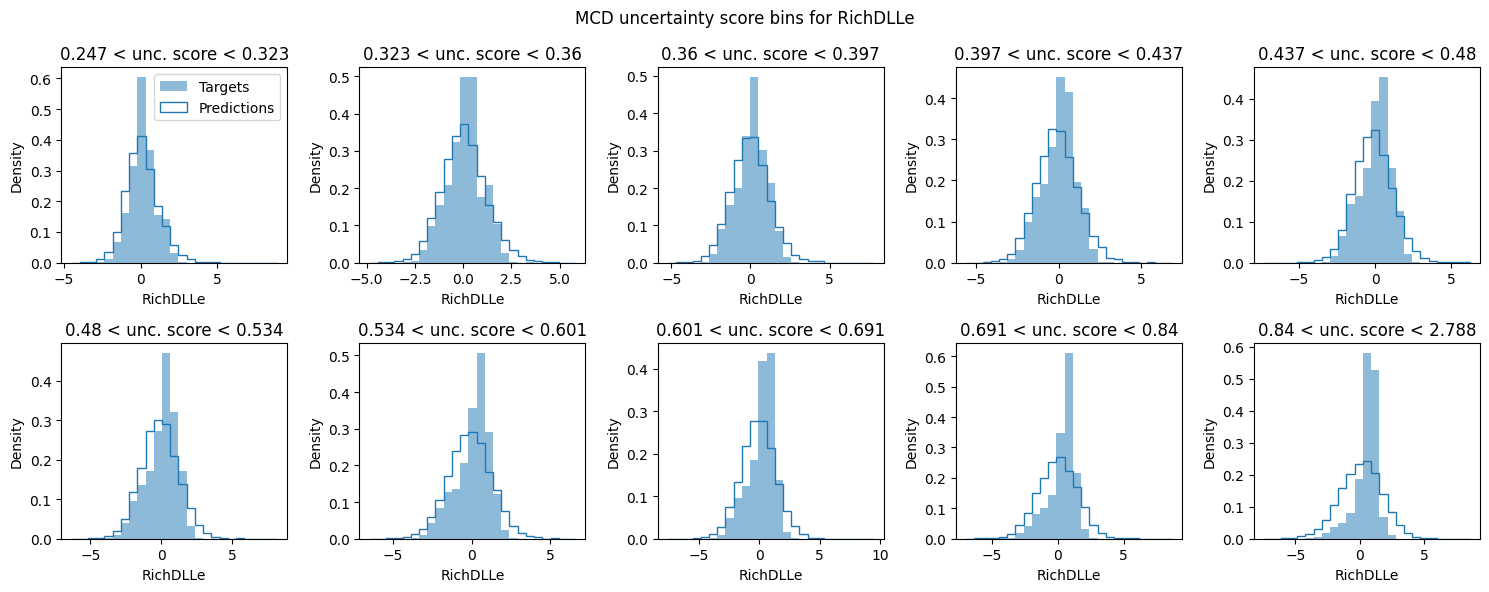

JS Distances:
0.14523402375553077, 0.1491489264932564, 0.14226153303956843, 0.15352660321861564, 0.1643250303429866, 0.17057311335303482, 0.1958246780247481, 0.21741148451038925, 0.2694712933783531, 0.334388735818607
0.057 < unc. score < 0.251: Number of observations: 10000
0.251 < unc. score < 0.321: Number of observations: 10000
0.321 < unc. score < 0.389: Number of observations: 10000
0.389 < unc. score < 0.465: Number of observations: 10000
0.465 < unc. score < 0.556: Number of observations: 10000
0.556 < unc. score < 0.669: Number of observations: 10000
0.669 < unc. score < 0.811: Number of observations: 10000
0.811 < unc. score < 1.01: Number of observations: 10000
1.01 < unc. score < 1.351: Number of observations: 10000
1.351 < unc. score < 5.267: Number of observations: 9999


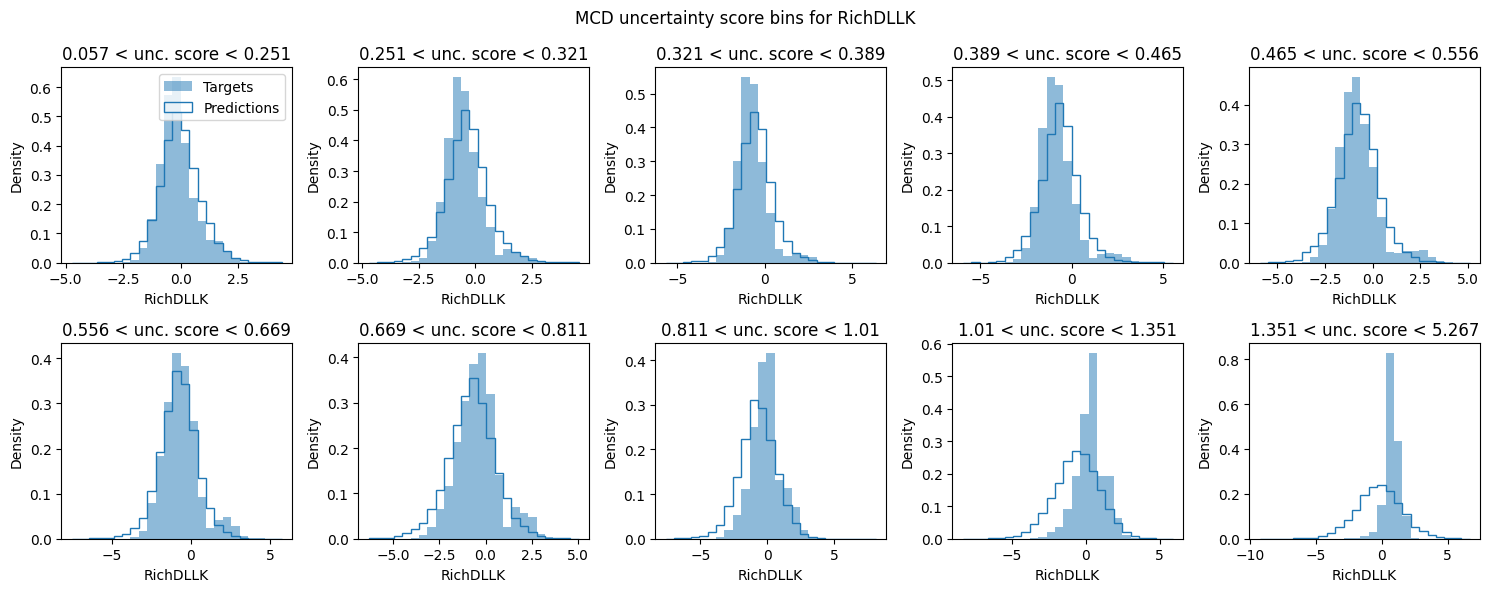

JS Distances:
0.11841346426336789, 0.14636012353499586, 0.16021989967856853, 0.1649360753999624, 0.14761751491241498, 0.1344684130538581, 0.15911484204092854, 0.20934162859305494, 0.3146647791653502, 0.4780271909934732
0.175 < unc. score < 0.241: Number of observations: 10000
0.241 < unc. score < 0.276: Number of observations: 10000
0.276 < unc. score < 0.309: Number of observations: 10000
0.309 < unc. score < 0.342: Number of observations: 10000
0.342 < unc. score < 0.378: Number of observations: 10000
0.378 < unc. score < 0.419: Number of observations: 10000
0.419 < unc. score < 0.467: Number of observations: 10000
0.467 < unc. score < 0.529: Number of observations: 10000
0.529 < unc. score < 0.63: Number of observations: 10000
0.63 < unc. score < 1.643: Number of observations: 9999


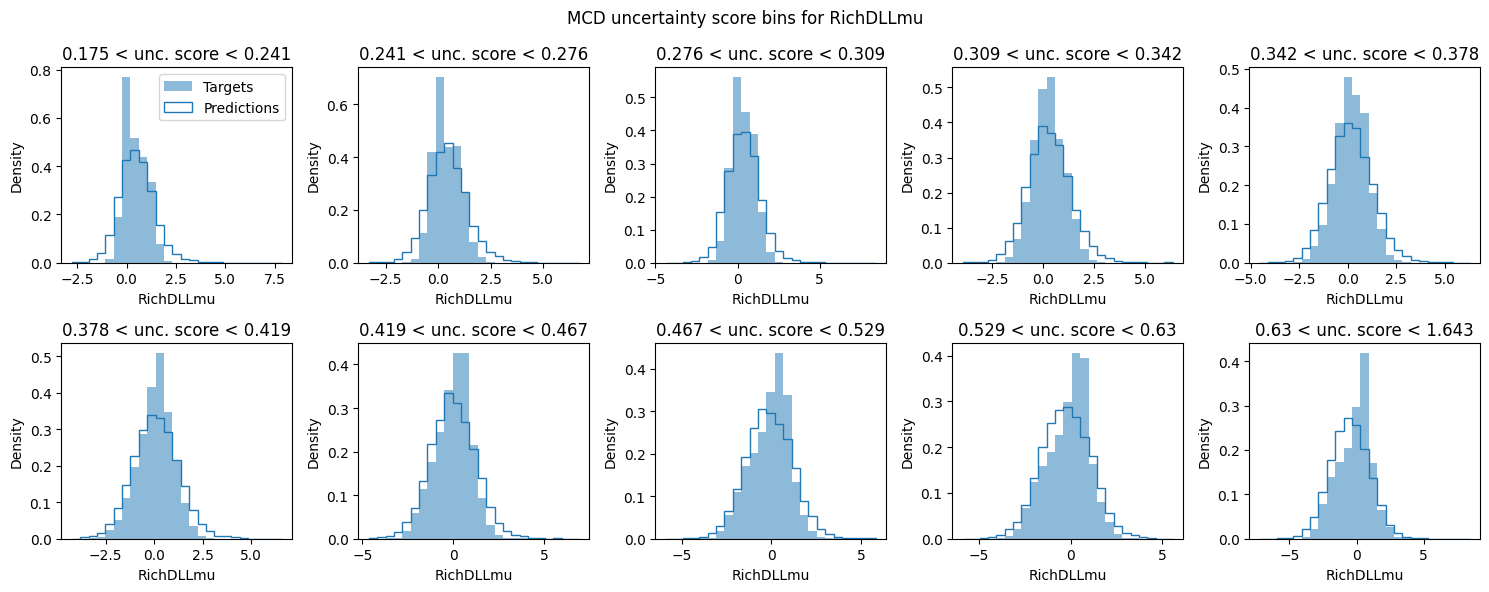

JS Distances:
0.22467762176594286, 0.2047636959231715, 0.17407842950864674, 0.1542774711792471, 0.14836033882701333, 0.14128193618816293, 0.13766630473609584, 0.13654058494443805, 0.13754182043212052, 0.15943673984632922
0.051 < unc. score < 0.248: Number of observations: 10000
0.248 < unc. score < 0.307: Number of observations: 10000
0.307 < unc. score < 0.363: Number of observations: 10000
0.363 < unc. score < 0.419: Number of observations: 10000
0.419 < unc. score < 0.484: Number of observations: 10000
0.484 < unc. score < 0.564: Number of observations: 10000
0.564 < unc. score < 0.668: Number of observations: 10000
0.668 < unc. score < 0.814: Number of observations: 10000
0.814 < unc. score < 1.069: Number of observations: 10000
1.069 < unc. score < 4.458: Number of observations: 9999


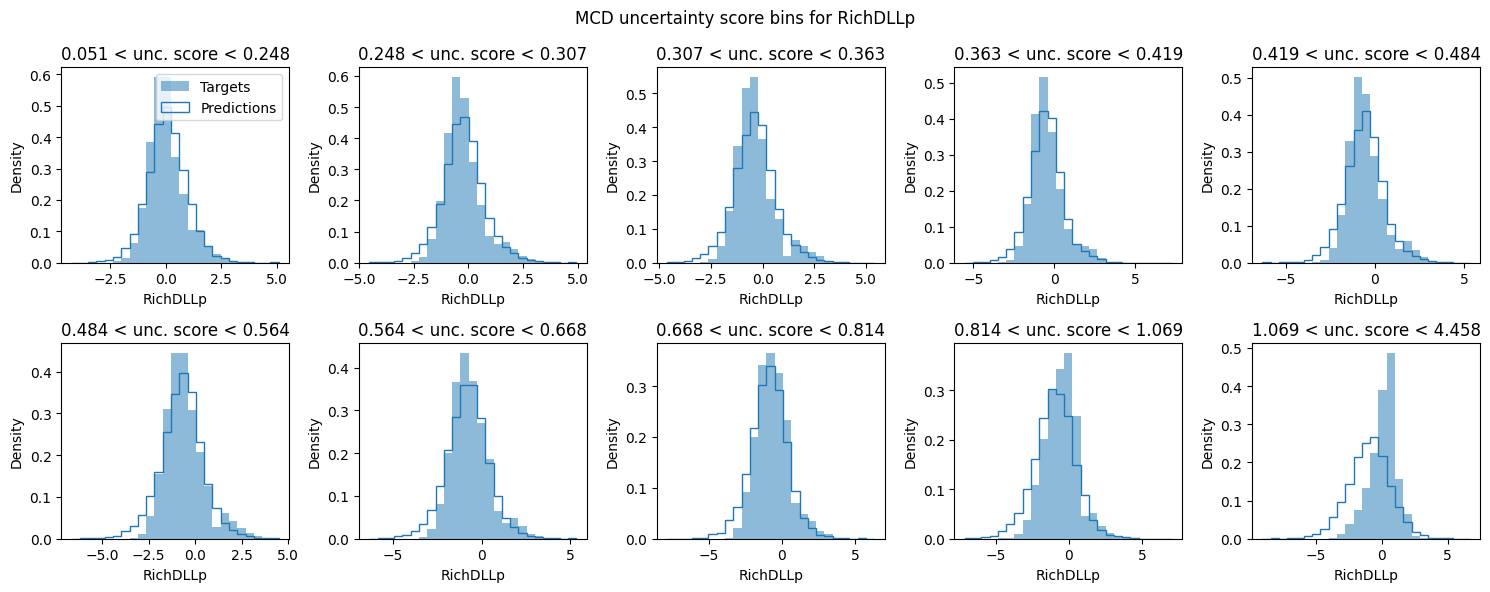

JS Distances:
0.1188038010265697, 0.12656930523202933, 0.14786817630534968, 0.12205788323169942, 0.13960848590689848, 0.14288126303405105, 0.13235768315595342, 0.13147435451247416, 0.17449612785682467, 0.32628611856319284
0.046 < unc. score < 0.26: Number of observations: 10000
0.26 < unc. score < 0.332: Number of observations: 10000
0.332 < unc. score < 0.399: Number of observations: 10000
0.399 < unc. score < 0.467: Number of observations: 10000
0.467 < unc. score < 0.545: Number of observations: 10000
0.545 < unc. score < 0.637: Number of observations: 10000
0.637 < unc. score < 0.758: Number of observations: 10000
0.758 < unc. score < 0.924: Number of observations: 10000
0.924 < unc. score < 1.196: Number of observations: 10000
1.196 < unc. score < 4.564: Number of observations: 9999


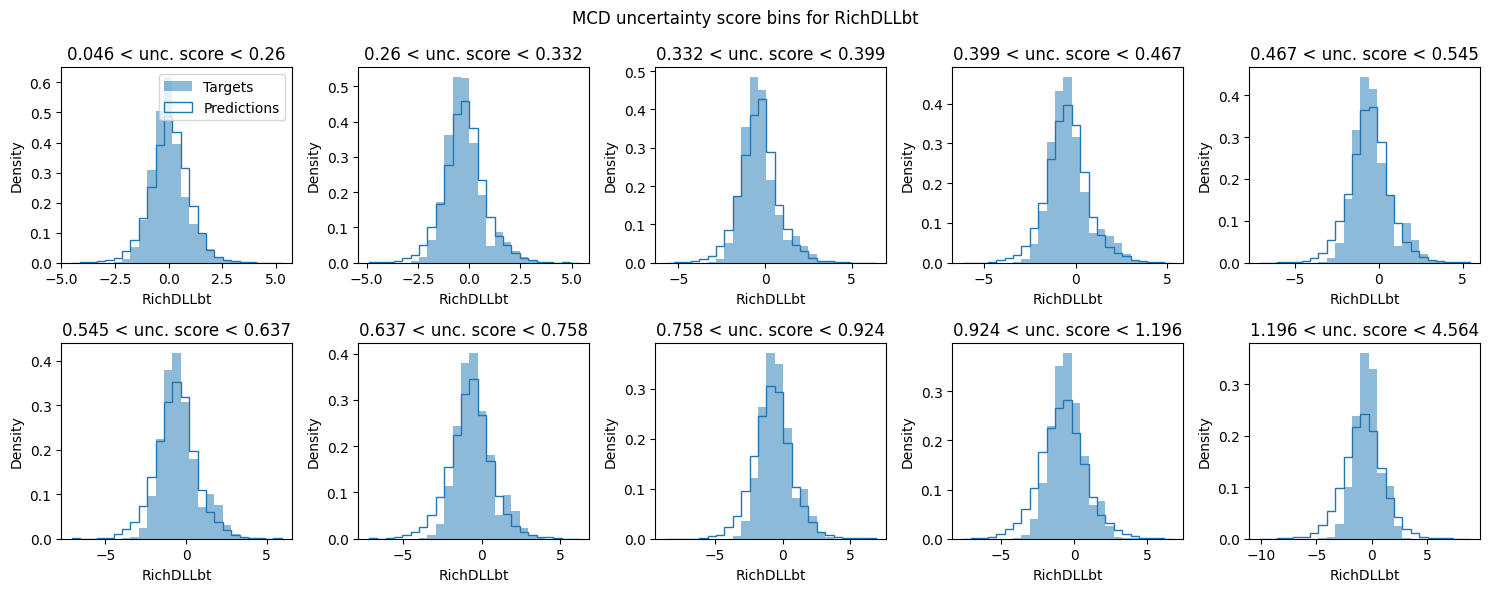

JS Distances:
0.10886195629002998, 0.1251651899170282, 0.12300879336323307, 0.12629688798838923, 0.14788286039608664, 0.14546483727473503, 0.15882834621806446, 0.15566151881525123, 0.18411081827715456, 0.22358608266305663


In [19]:
all_mcd_bin_edges, all_mcd_js_distances = [], []

metric = 'JS'
#metric = 'KS'

for i in range(5):
  mcd_bin_edges, mcd_js_distances = estimate_distances_and_plot_uncertainty_bins(
      y_sample, t_generated, mcd_final_uncertainty, uncertainty_type = 'MCD', bin_type='quantiles', particle_index = i, metric=metric)
  all_mcd_bin_edges += [mcd_bin_edges]
  all_mcd_js_distances += [mcd_js_distances]

Correlation coefficient for RichDLLe: 0.9318744181631909
Correlation coefficient for RichDLLK: 0.9596999306661192
Correlation coefficient for RichDLLmu: -0.38143826222830995
Correlation coefficient for RichDLLp: 0.9753341649489287
Correlation coefficient for RichDLLbt: 0.9311745880051105


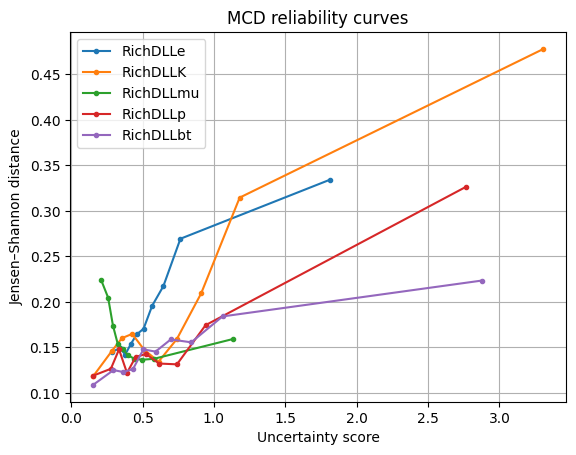

In [20]:
plot_all_distances(all_mcd_bin_edges, all_mcd_js_distances, 'MCD', metric=metric)

#### KS / Quantile bins

0.247 < unc. score < 0.323: Number of observations: 10000
0.323 < unc. score < 0.36: Number of observations: 10000
0.36 < unc. score < 0.397: Number of observations: 10000
0.397 < unc. score < 0.437: Number of observations: 10000
0.437 < unc. score < 0.48: Number of observations: 10000
0.48 < unc. score < 0.534: Number of observations: 10000
0.534 < unc. score < 0.601: Number of observations: 10000
0.601 < unc. score < 0.691: Number of observations: 10000
0.691 < unc. score < 0.84: Number of observations: 10000
0.84 < unc. score < 2.788: Number of observations: 9999


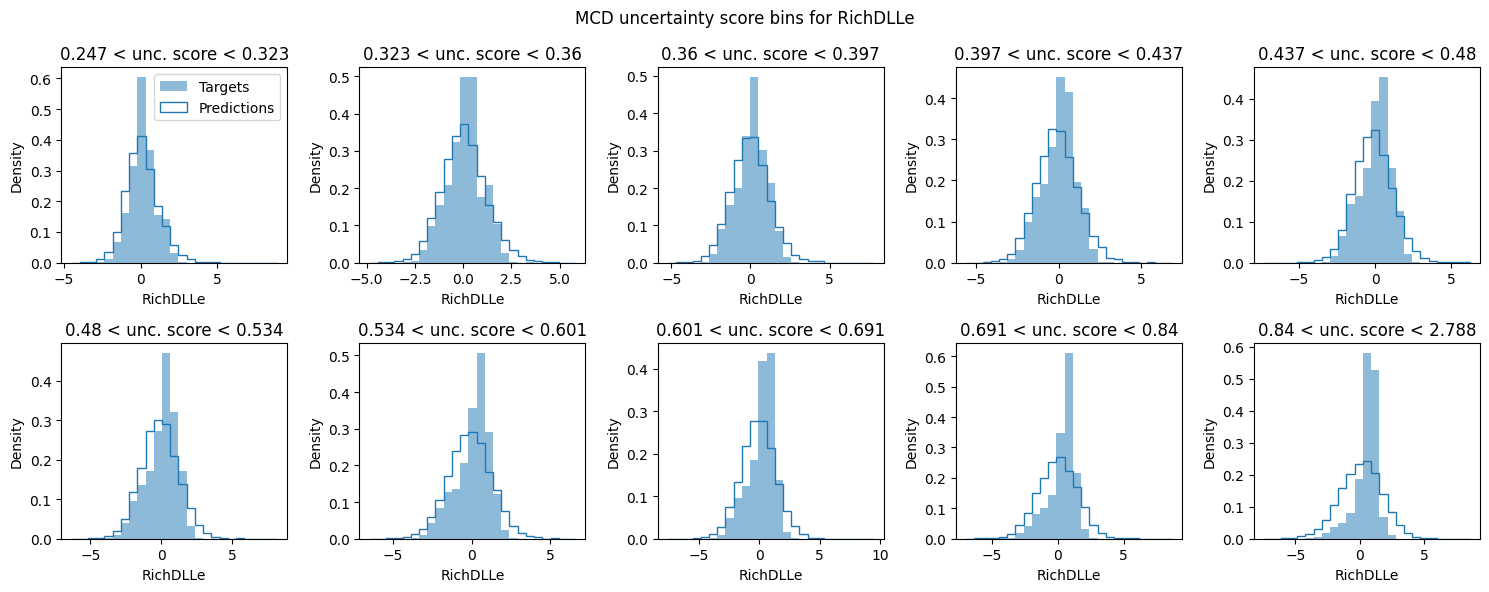

KS Distances:
0.102, 0.0898, 0.1044, 0.1123, 0.1306, 0.1438, 0.1594, 0.1925, 0.2334, 0.2883288328832883
0.057 < unc. score < 0.251: Number of observations: 10000
0.251 < unc. score < 0.321: Number of observations: 10000
0.321 < unc. score < 0.389: Number of observations: 10000
0.389 < unc. score < 0.465: Number of observations: 10000
0.465 < unc. score < 0.556: Number of observations: 10000
0.556 < unc. score < 0.669: Number of observations: 10000
0.669 < unc. score < 0.811: Number of observations: 10000
0.811 < unc. score < 1.01: Number of observations: 10000
1.01 < unc. score < 1.351: Number of observations: 10000
1.351 < unc. score < 5.267: Number of observations: 9999


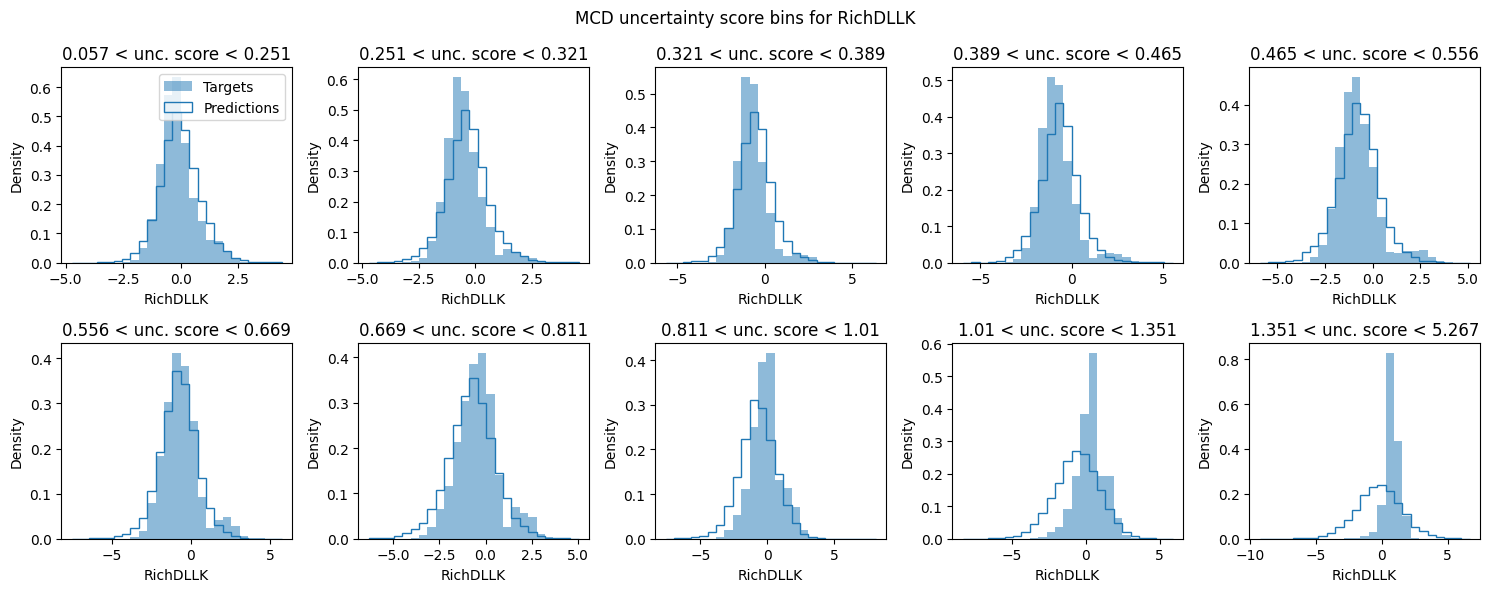

KS Distances:
0.1073, 0.132, 0.1489, 0.129, 0.0674, 0.0605, 0.1284, 0.2363, 0.3548, 0.5018501850185019
0.175 < unc. score < 0.241: Number of observations: 10000
0.241 < unc. score < 0.276: Number of observations: 10000
0.276 < unc. score < 0.309: Number of observations: 10000
0.309 < unc. score < 0.342: Number of observations: 10000
0.342 < unc. score < 0.378: Number of observations: 10000
0.378 < unc. score < 0.419: Number of observations: 10000
0.419 < unc. score < 0.467: Number of observations: 10000
0.467 < unc. score < 0.529: Number of observations: 10000
0.529 < unc. score < 0.63: Number of observations: 10000
0.63 < unc. score < 1.643: Number of observations: 9999


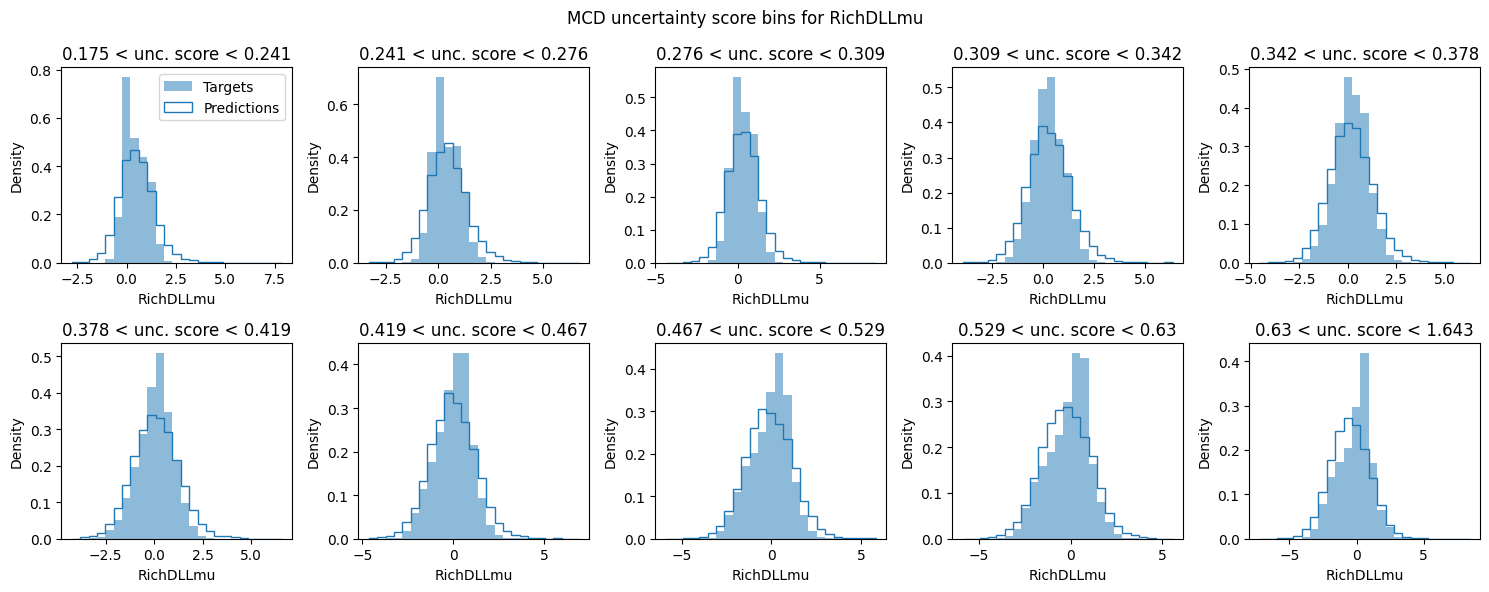

KS Distances:
0.1068, 0.0995, 0.0877, 0.0734, 0.0786, 0.0741, 0.0747, 0.0864, 0.101, 0.1638163816381638
0.051 < unc. score < 0.248: Number of observations: 10000
0.248 < unc. score < 0.307: Number of observations: 10000
0.307 < unc. score < 0.363: Number of observations: 10000
0.363 < unc. score < 0.419: Number of observations: 10000
0.419 < unc. score < 0.484: Number of observations: 10000
0.484 < unc. score < 0.564: Number of observations: 10000
0.564 < unc. score < 0.668: Number of observations: 10000
0.668 < unc. score < 0.814: Number of observations: 10000
0.814 < unc. score < 1.069: Number of observations: 10000
1.069 < unc. score < 4.458: Number of observations: 9999


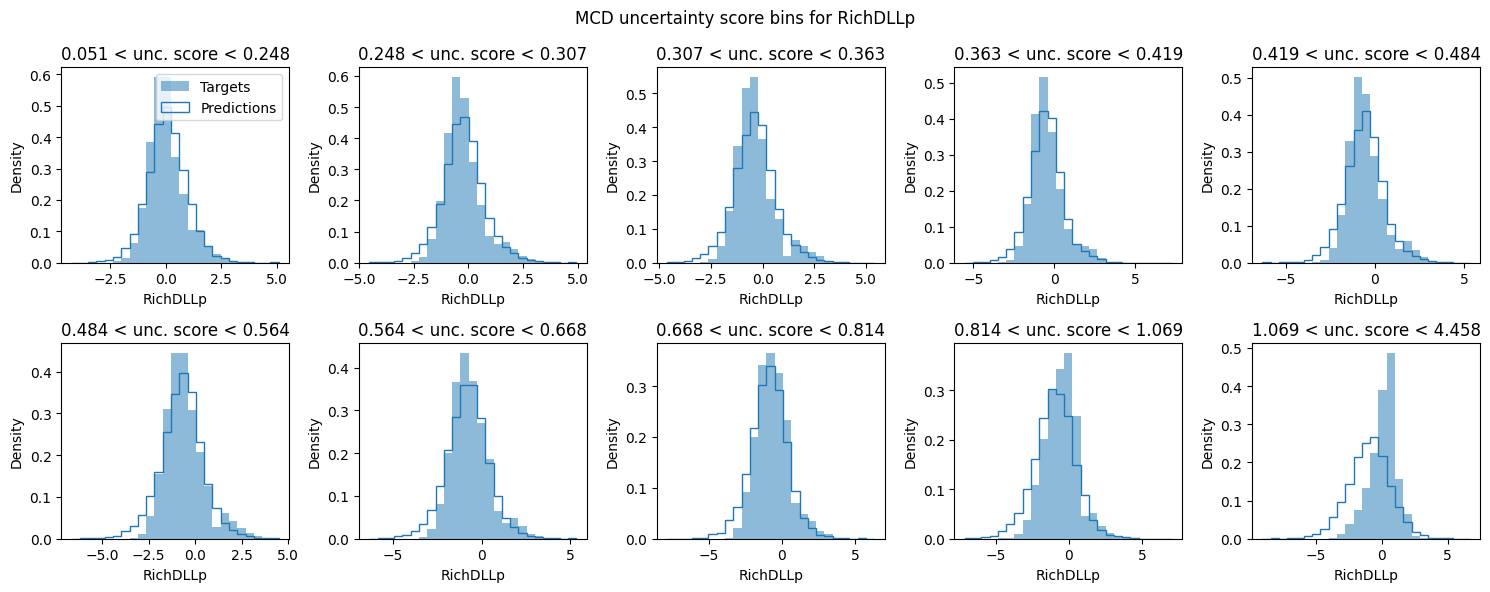

KS Distances:
0.0916, 0.0757, 0.0739, 0.063, 0.0726, 0.0728, 0.0799, 0.0893, 0.1546, 0.37213721372137215
0.046 < unc. score < 0.26: Number of observations: 10000
0.26 < unc. score < 0.332: Number of observations: 10000
0.332 < unc. score < 0.399: Number of observations: 10000
0.399 < unc. score < 0.467: Number of observations: 10000
0.467 < unc. score < 0.545: Number of observations: 10000
0.545 < unc. score < 0.637: Number of observations: 10000
0.637 < unc. score < 0.758: Number of observations: 10000
0.758 < unc. score < 0.924: Number of observations: 10000
0.924 < unc. score < 1.196: Number of observations: 10000
1.196 < unc. score < 4.564: Number of observations: 9999


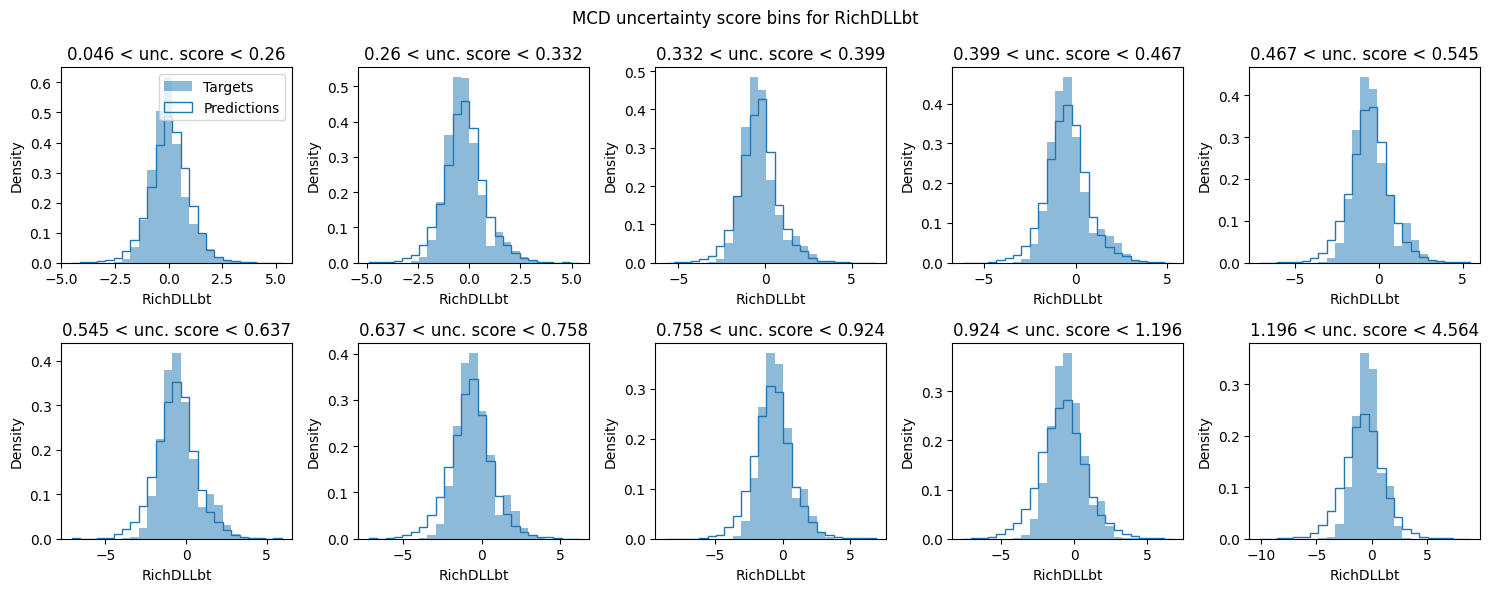

KS Distances:
0.0857, 0.0631, 0.0573, 0.0625, 0.0794, 0.0878, 0.1059, 0.1178, 0.1506, 0.1706170617061706


In [28]:
all_mcd_bin_edges, all_mcd_js_distances = [], []

# metric = 'JS'
metric = 'KS'

for i in range(5):
  mcd_bin_edges, mcd_js_distances = estimate_distances_and_plot_uncertainty_bins(
      y_sample, t_generated, mcd_final_uncertainty, uncertainty_type = 'MCD', bin_type='quantiles', particle_index = i, metric=metric)
  all_mcd_bin_edges += [mcd_bin_edges]
  all_mcd_js_distances += [mcd_js_distances]

Correlation coefficient for RichDLLe: 0.9034463298342998
Correlation coefficient for RichDLLK: 0.8965327911848345
Correlation coefficient for RichDLLmu: 0.775879140998295
Correlation coefficient for RichDLLp: 0.9715665977016187
Correlation coefficient for RichDLLbt: 0.8451796829258251


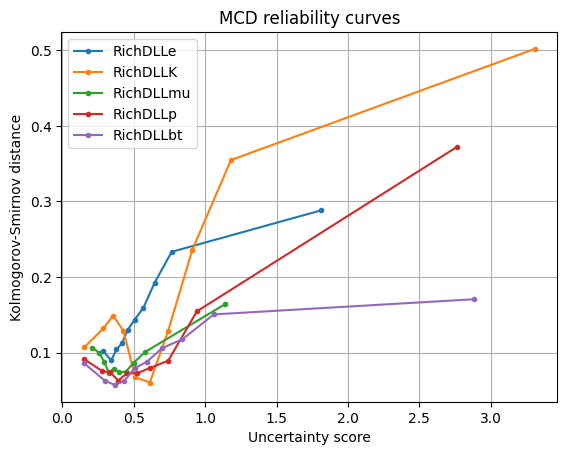

In [29]:
plot_all_distances(all_mcd_bin_edges, all_mcd_js_distances, 'MCD', metric=metric)

## Feature Densities method

### Generation of FD embeddings

In [ ]:
# from feature_densities.feature_density_evaluator import create_embeddings_model
# embeddings_model = create_embeddings_model(model)
# train_embeddings, train_predictions = embeddings_model.predict(dataset['feats_train'])
# test_embeddings, test_predictions = embeddings_model.predict(dataset['feats_val'])

# !rm -r embeddings
# !mkdir embeddings

# np.save(embeddings_dir + f'{PARTICLE}_train_embeddings.npy', train_embeddings)
# np.save(embeddings_dir + f'{PARTICLE}_train_predictions.npy', train_predictions)
# np.save(embeddings_dir + f'{PARTICLE}_test_embeddings.npy', test_embeddings)
# np.save(embeddings_dir + f'{PARTICLE}_test_predictions.npy', test_predictions)

### Uncertainty estimation

In [34]:
train_embeddings = np.load(embeddings_dir + f'{PARTICLE}_train_embeddings.npy')
train_embeddings.shape

(948325, 128)

In [35]:
print('Generating an embeddings model')
layer = 8
embeddings_model = create_embeddings_model(model, layer)

print('Generating histograms')
n_bins = 30
probs, hists = get_histogram(train_embeddings, n_bins)

Generating an embeddings model
Generating histograms


In [36]:
def fd_uncertainties_experiment(repetitions=N):

  fd_uncertainties = []
  fd_duration = []
  
  for _ in trange(repetitions):
    # Start the timer
    start_time = time.time()
    fd_unc, _ = fd_evaluate_model(embeddings_model, x_sample, probs, hists, n_bins, likelihood_method='histograms')
    fd_duration.append(time.time() - start_time)
    fd_uncertainties.append(fd_unc)
  
  stacked_fd = tf.stack(fd_uncertainties)
  average_fd = tf.reduce_mean(stacked_fd, axis=0)
  return average_fd, stacked_fd, fd_duration

def fd_global_experiment(global_repetitions=N):
  fd_all_uncertainties = []
  fd_all_durations = []

  for i in range(global_repetitions):
    print(f'FD Experiment Run {i + 1} of {N}')
    average_fd, _, fd_duration = fd_uncertainties_experiment()
    fd_all_uncertainties.append(average_fd)
    fd_all_durations.append(fd_duration)    

  return fd_all_uncertainties, fd_all_durations


In [ ]:
fd_all_uncertainties, fd_all_durations = fd_global_experiment()

In [47]:
fd_avg_duration = np.mean(fd_all_durations)
fd_std_duration = np.std(fd_all_durations)

print(f"FD Average duration:\t{fd_avg_duration} seconds")
print(f"FD Std duration:\t\t{fd_std_duration} seconds")

# Save FD duration
np.save(f'{output_dir}/{PARTICLE}_fd_layer{layer}_duration_list.npy', fd_all_durations)

# Save FD uncertainties
np.save(f'{output_dir}/{PARTICLE}_fd_uncertainty_layer{layer}.npy', fd_all_uncertainties)

FD Average duration:	0.21457638051774766 seconds
FD Std duration:		0.012819254644603413 seconds


In [46]:
stacked_fd_uncertainty = tf.stack(fd_all_uncertainties)
fd_uncertainty_normalized = tf.reduce_mean(stacked_fd_uncertainty, axis=0)

print(f'Feature Densities using Averaged uncertainty score for x_sample:{fd_uncertainty_normalized.shape}')

# Save FD uncertainties normalized
np.save(f'{output_dir}/{PARTICLE}_fd_uncertainty_layer{layer}_normalized.npy', fd_uncertainty_normalized)

Feature Densities using Averaged uncertainty score for x_sample:(100000,)


### Plot FD uncertainties

#### JS / Quantile bins

0.886 < unc. score < 0.908: Number of observations: 10000
0.908 < unc. score < 0.915: Number of observations: 10000
0.915 < unc. score < 0.92: Number of observations: 10000
0.92 < unc. score < 0.925: Number of observations: 10000
0.925 < unc. score < 0.929: Number of observations: 10000
0.929 < unc. score < 0.934: Number of observations: 10000
0.934 < unc. score < 0.938: Number of observations: 10000
0.938 < unc. score < 0.944: Number of observations: 10000
0.944 < unc. score < 0.952: Number of observations: 10000
0.952 < unc. score < 0.978: Number of observations: 9999


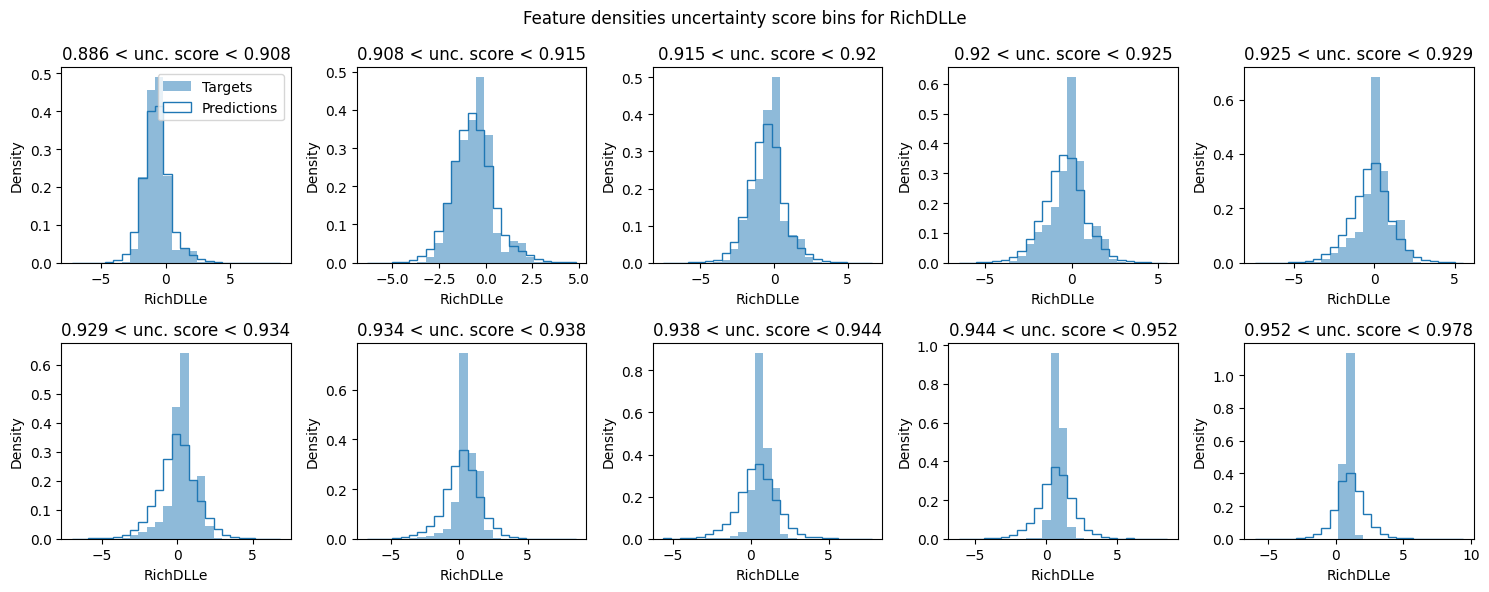

JS Distances:
0.11947144792533529, 0.12711410169556753, 0.13497544390100136, 0.1683893355106124, 0.19595862528734923, 0.23807819936400135, 0.28846911630152455, 0.34719901552830673, 0.40959271306796136, 0.4663479003402192
0.886 < unc. score < 0.908: Number of observations: 10000
0.908 < unc. score < 0.915: Number of observations: 10000
0.915 < unc. score < 0.92: Number of observations: 10000
0.92 < unc. score < 0.925: Number of observations: 10000
0.925 < unc. score < 0.929: Number of observations: 10000
0.929 < unc. score < 0.934: Number of observations: 10000
0.934 < unc. score < 0.938: Number of observations: 10000
0.938 < unc. score < 0.944: Number of observations: 10000
0.944 < unc. score < 0.952: Number of observations: 10000
0.952 < unc. score < 0.978: Number of observations: 9999


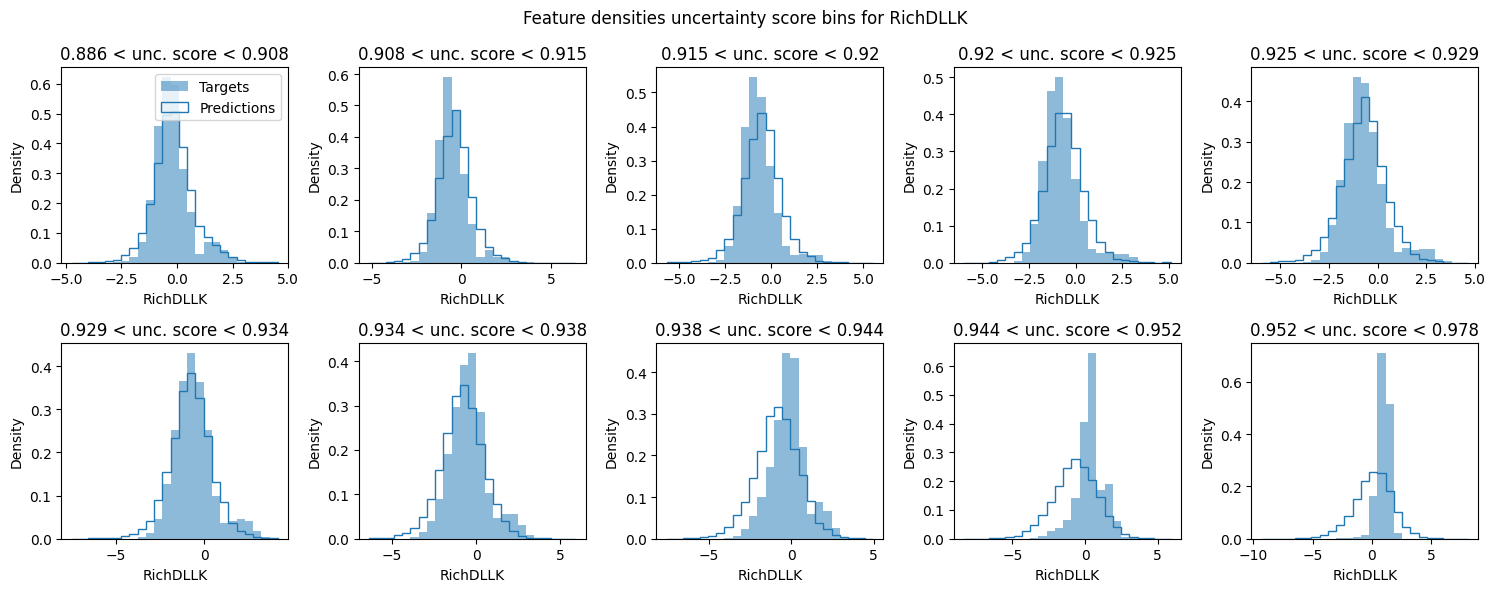

JS Distances:
0.13367301750868688, 0.15449359870470333, 0.16874157968391001, 0.1564540499899244, 0.14932792501020498, 0.13137575465438686, 0.16052818204167663, 0.23549684103906215, 0.3492799456554181, 0.4569789519396778
0.886 < unc. score < 0.908: Number of observations: 10000
0.908 < unc. score < 0.915: Number of observations: 10000
0.915 < unc. score < 0.92: Number of observations: 10000
0.92 < unc. score < 0.925: Number of observations: 10000
0.925 < unc. score < 0.929: Number of observations: 10000
0.929 < unc. score < 0.934: Number of observations: 10000
0.934 < unc. score < 0.938: Number of observations: 10000
0.938 < unc. score < 0.944: Number of observations: 10000
0.944 < unc. score < 0.952: Number of observations: 10000
0.952 < unc. score < 0.978: Number of observations: 9999


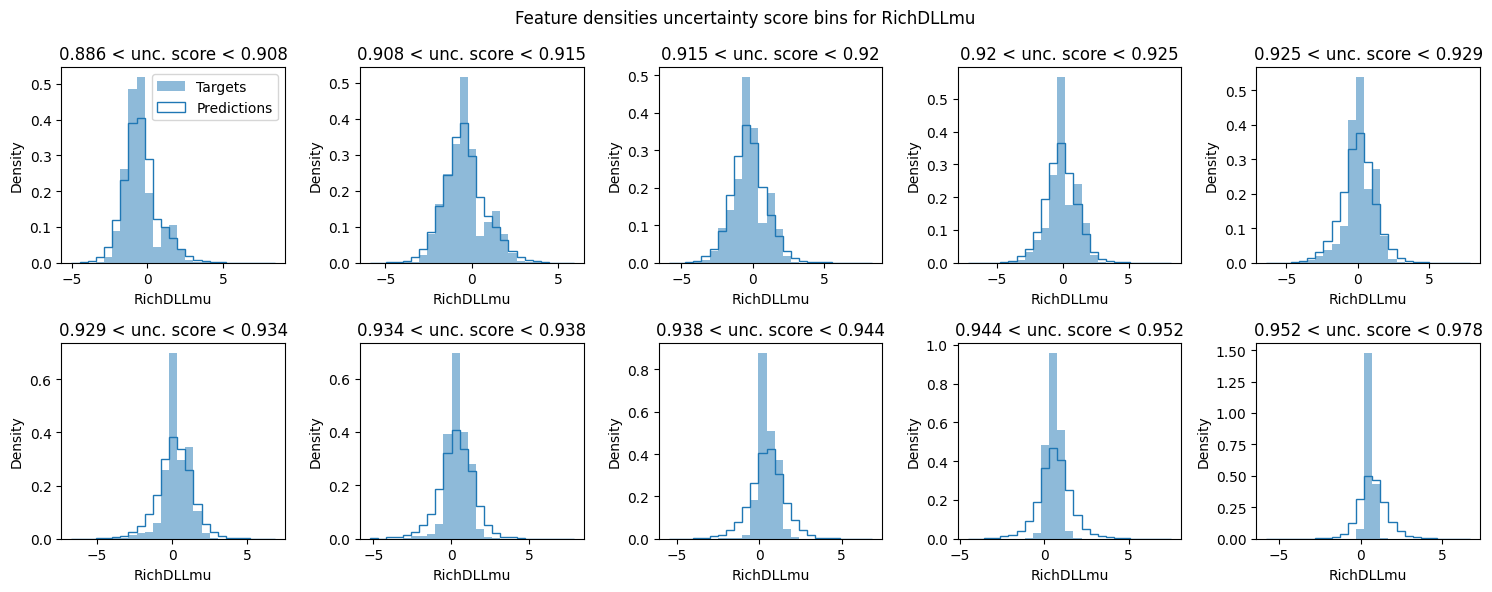

JS Distances:
0.14050744674448223, 0.11756166013670424, 0.1259724310208329, 0.14675505812879144, 0.16315759527458856, 0.1964210232296999, 0.230132289163492, 0.300406162640033, 0.3501178250803142, 0.4484458981481879
0.886 < unc. score < 0.908: Number of observations: 10000
0.908 < unc. score < 0.915: Number of observations: 10000
0.915 < unc. score < 0.92: Number of observations: 10000
0.92 < unc. score < 0.925: Number of observations: 10000
0.925 < unc. score < 0.929: Number of observations: 10000
0.929 < unc. score < 0.934: Number of observations: 10000
0.934 < unc. score < 0.938: Number of observations: 10000
0.938 < unc. score < 0.944: Number of observations: 10000
0.944 < unc. score < 0.952: Number of observations: 10000
0.952 < unc. score < 0.978: Number of observations: 9999


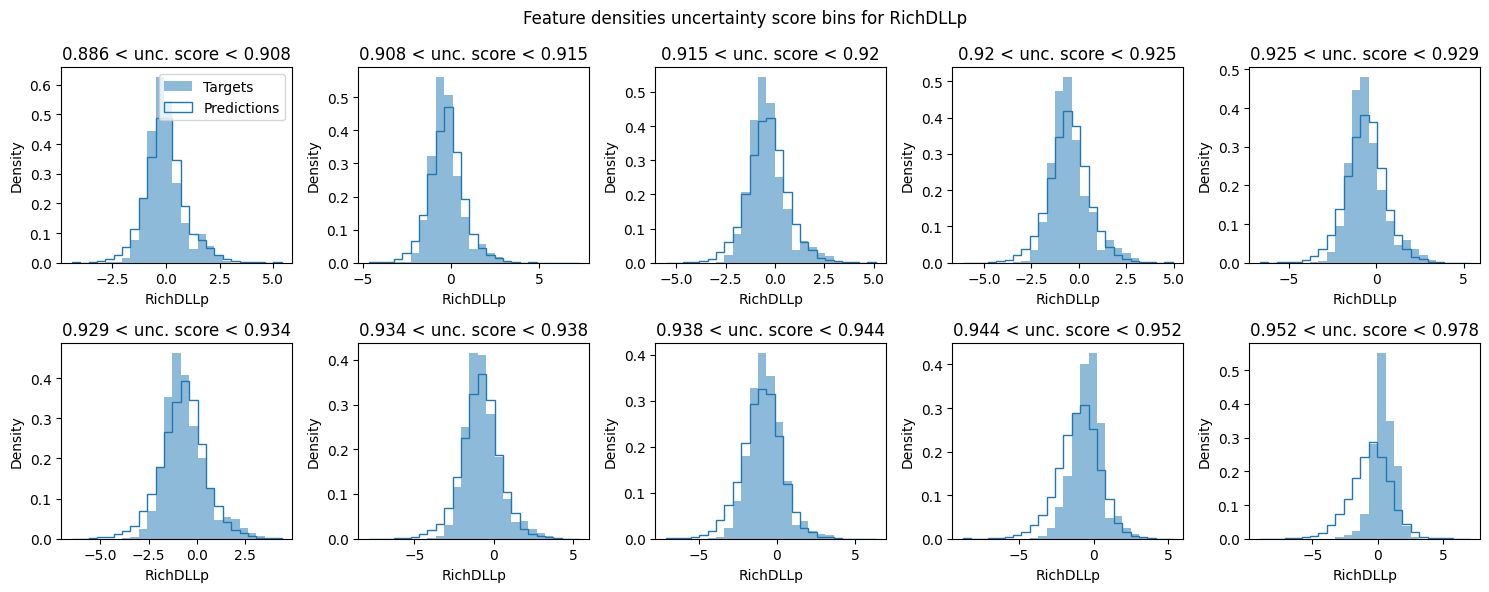

JS Distances:
0.12283922475755465, 0.12583928269749578, 0.14125823634459514, 0.142007552103273, 0.14075561335724565, 0.14064084497413096, 0.1254529130766737, 0.13847712366326792, 0.21587132941509712, 0.3541350364087367
0.886 < unc. score < 0.908: Number of observations: 10000
0.908 < unc. score < 0.915: Number of observations: 10000
0.915 < unc. score < 0.92: Number of observations: 10000
0.92 < unc. score < 0.925: Number of observations: 10000
0.925 < unc. score < 0.929: Number of observations: 10000
0.929 < unc. score < 0.934: Number of observations: 10000
0.934 < unc. score < 0.938: Number of observations: 10000
0.938 < unc. score < 0.944: Number of observations: 10000
0.944 < unc. score < 0.952: Number of observations: 10000
0.952 < unc. score < 0.978: Number of observations: 9999


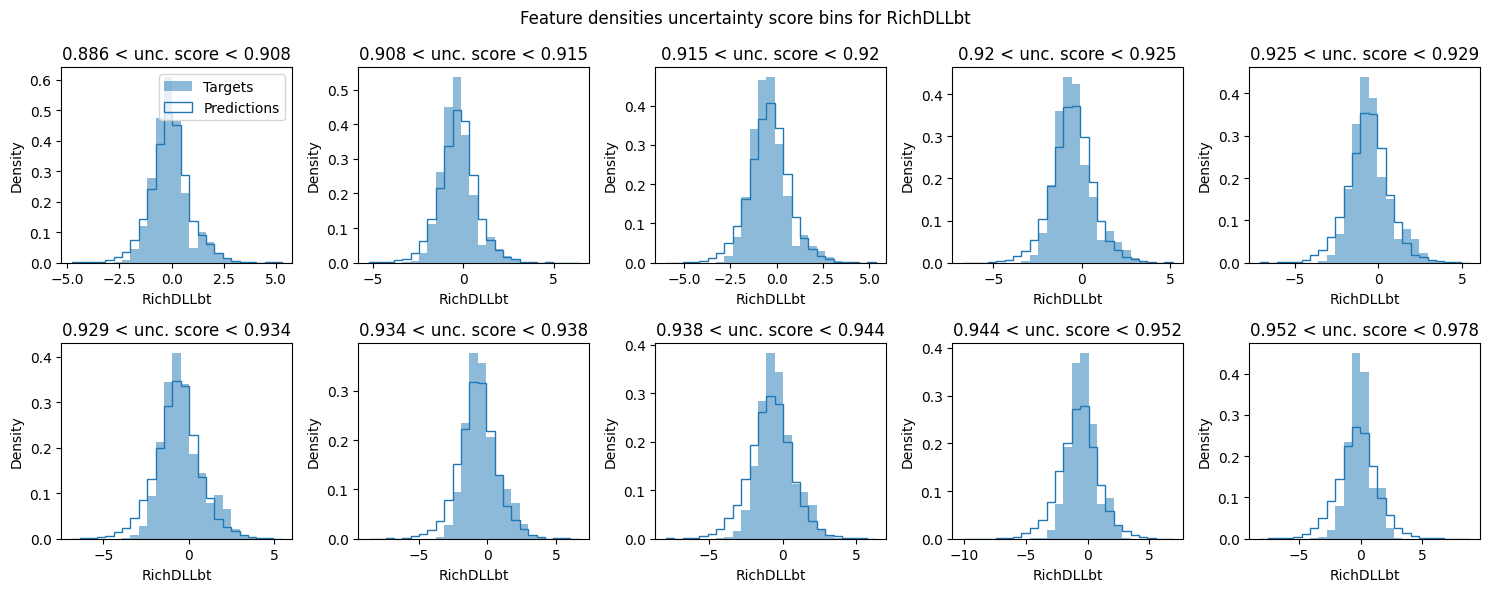

JS Distances:
0.12140652101425288, 0.12405227333837977, 0.13385998418737172, 0.136401233597643, 0.14683638209941863, 0.1496571593308294, 0.14870868929700168, 0.16671172175827179, 0.20103806644612626, 0.23886168714509012


In [48]:
all_fd_bin_edges, all_fd_js_distances = [], []

metric = 'JS'
#metric = 'KS'

for i in range(5):
  fd_bin_edges, fd_js_distances = estimate_distances_and_plot_uncertainty_bins(
      y_sample, t_generated, fd_uncertainty_normalized, 'Feature densities', 'quantiles', particle_index = i, metric=metric)

  all_fd_bin_edges += [fd_bin_edges]
  all_fd_js_distances += [fd_js_distances]

Correlation coefficient for RichDLLe: 0.9529140424205061
Correlation coefficient for RichDLLK: 0.8270533980588306
Correlation coefficient for RichDLLmu: 0.9184570005903921
Correlation coefficient for RichDLLp: 0.7722191660272327
Correlation coefficient for RichDLLbt: 0.9286004342895892


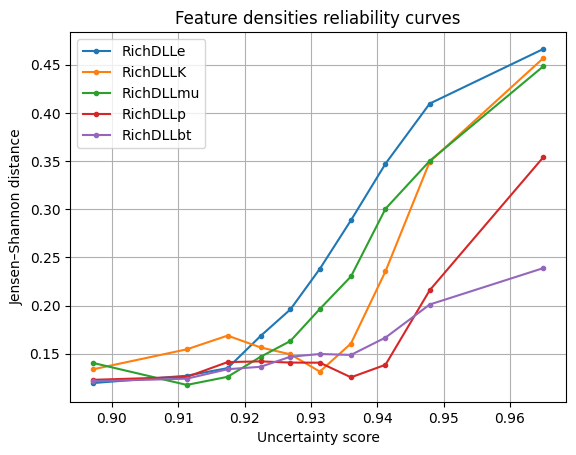

In [49]:
plot_all_distances(all_fd_bin_edges, all_fd_js_distances, 'Feature densities', metric=metric)

#### KS / Quantile bins

0.886 < unc. score < 0.908: Number of observations: 10000
0.908 < unc. score < 0.915: Number of observations: 10000
0.915 < unc. score < 0.92: Number of observations: 10000
0.92 < unc. score < 0.925: Number of observations: 10000
0.925 < unc. score < 0.929: Number of observations: 10000
0.929 < unc. score < 0.934: Number of observations: 10000
0.934 < unc. score < 0.938: Number of observations: 10000
0.938 < unc. score < 0.944: Number of observations: 10000
0.944 < unc. score < 0.952: Number of observations: 10000
0.952 < unc. score < 0.978: Number of observations: 9999


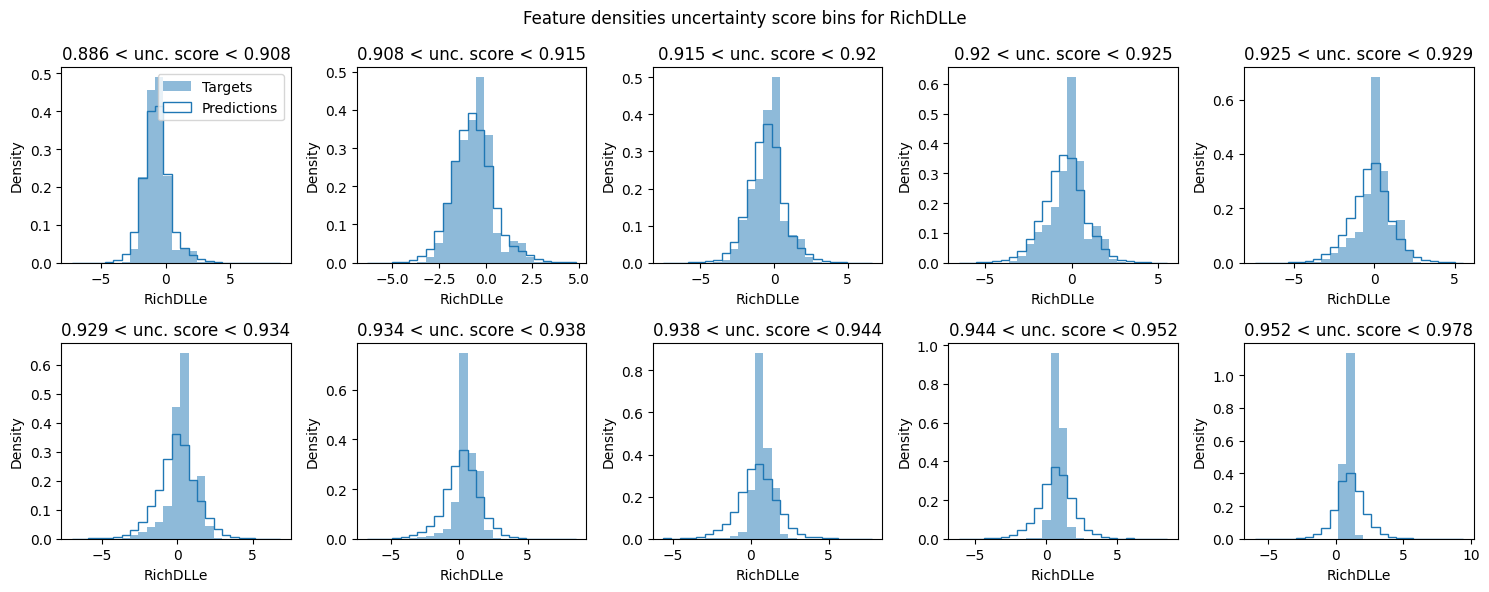

KS Distances:
0.0574, 0.0593, 0.113, 0.1747, 0.2096, 0.2484, 0.2799, 0.3103, 0.2939, 0.35693569356935695
0.886 < unc. score < 0.908: Number of observations: 10000
0.908 < unc. score < 0.915: Number of observations: 10000
0.915 < unc. score < 0.92: Number of observations: 10000
0.92 < unc. score < 0.925: Number of observations: 10000
0.925 < unc. score < 0.929: Number of observations: 10000
0.929 < unc. score < 0.934: Number of observations: 10000
0.934 < unc. score < 0.938: Number of observations: 10000
0.938 < unc. score < 0.944: Number of observations: 10000
0.944 < unc. score < 0.952: Number of observations: 10000
0.952 < unc. score < 0.978: Number of observations: 9999


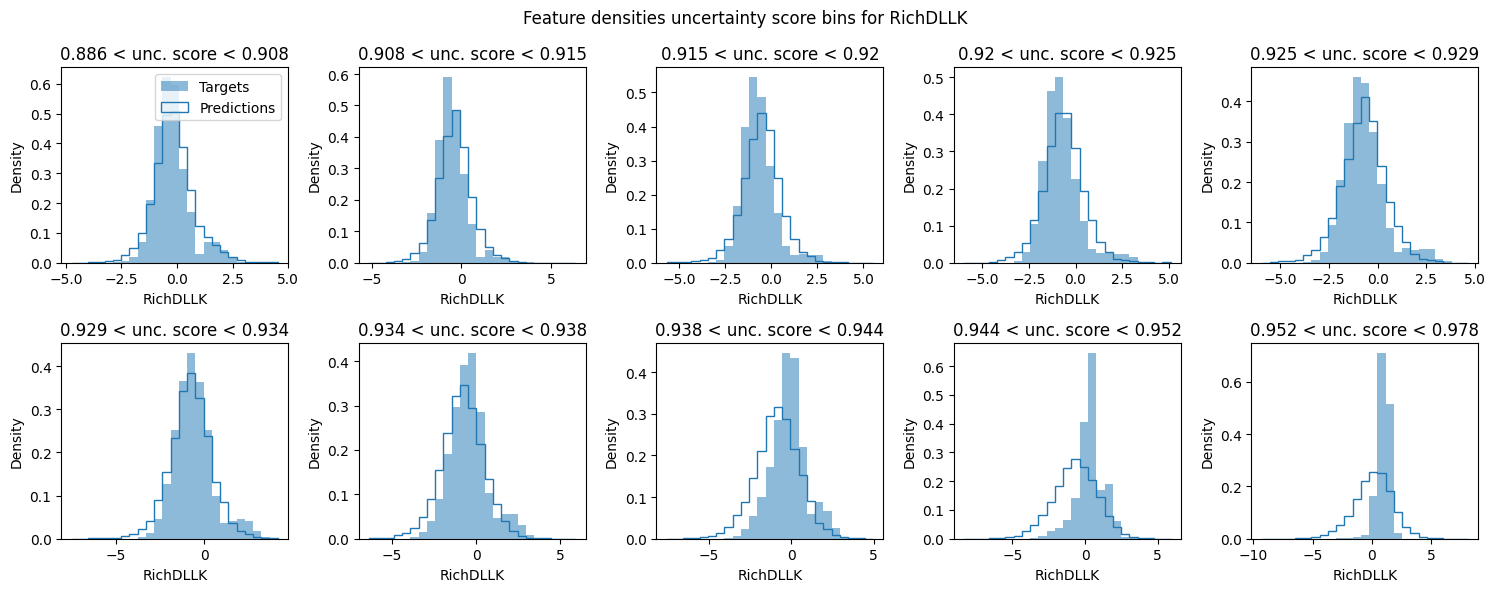

KS Distances:
0.0961, 0.1365, 0.151, 0.1218, 0.0646, 0.0667, 0.1329, 0.264, 0.416, 0.46074607460746075
0.886 < unc. score < 0.908: Number of observations: 10000
0.908 < unc. score < 0.915: Number of observations: 10000
0.915 < unc. score < 0.92: Number of observations: 10000
0.92 < unc. score < 0.925: Number of observations: 10000
0.925 < unc. score < 0.929: Number of observations: 10000
0.929 < unc. score < 0.934: Number of observations: 10000
0.934 < unc. score < 0.938: Number of observations: 10000
0.938 < unc. score < 0.944: Number of observations: 10000
0.944 < unc. score < 0.952: Number of observations: 10000
0.952 < unc. score < 0.978: Number of observations: 9999


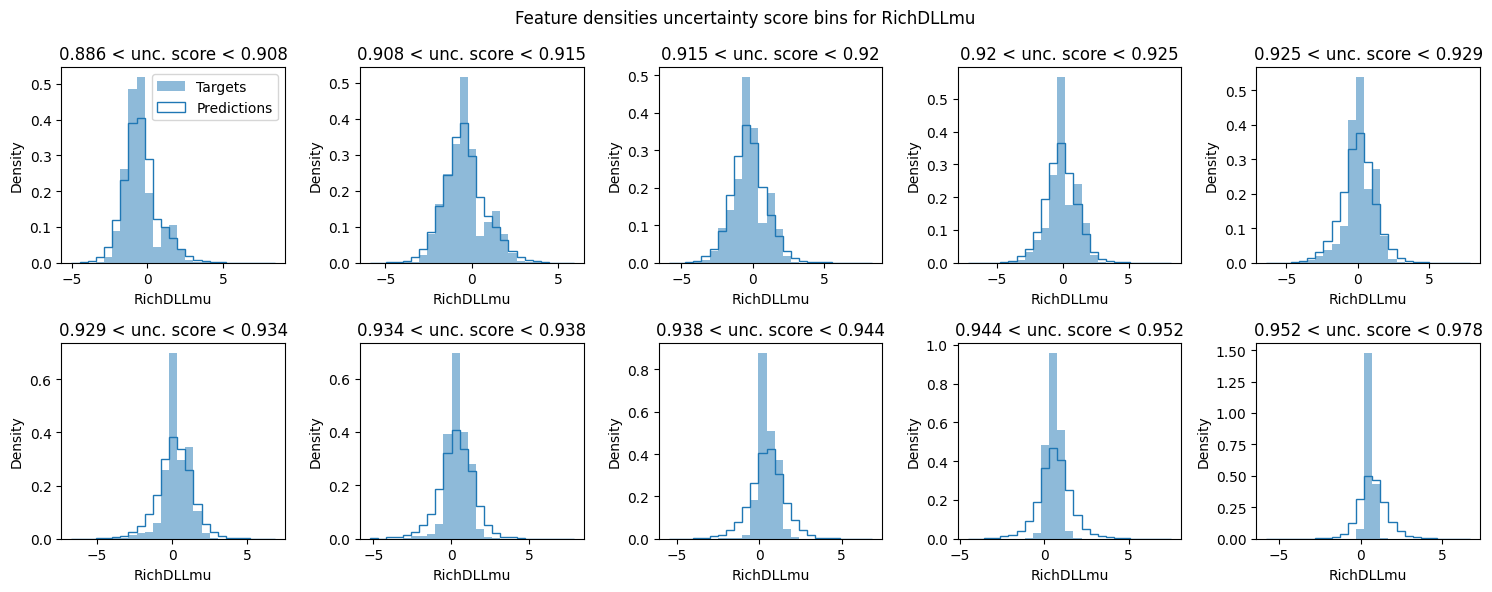

KS Distances:
0.0899, 0.0534, 0.0705, 0.1146, 0.1348, 0.161, 0.1709, 0.1843, 0.229, 0.341034103410341
0.886 < unc. score < 0.908: Number of observations: 10000
0.908 < unc. score < 0.915: Number of observations: 10000
0.915 < unc. score < 0.92: Number of observations: 10000
0.92 < unc. score < 0.925: Number of observations: 10000
0.925 < unc. score < 0.929: Number of observations: 10000
0.929 < unc. score < 0.934: Number of observations: 10000
0.934 < unc. score < 0.938: Number of observations: 10000
0.938 < unc. score < 0.944: Number of observations: 10000
0.944 < unc. score < 0.952: Number of observations: 10000
0.952 < unc. score < 0.978: Number of observations: 9999


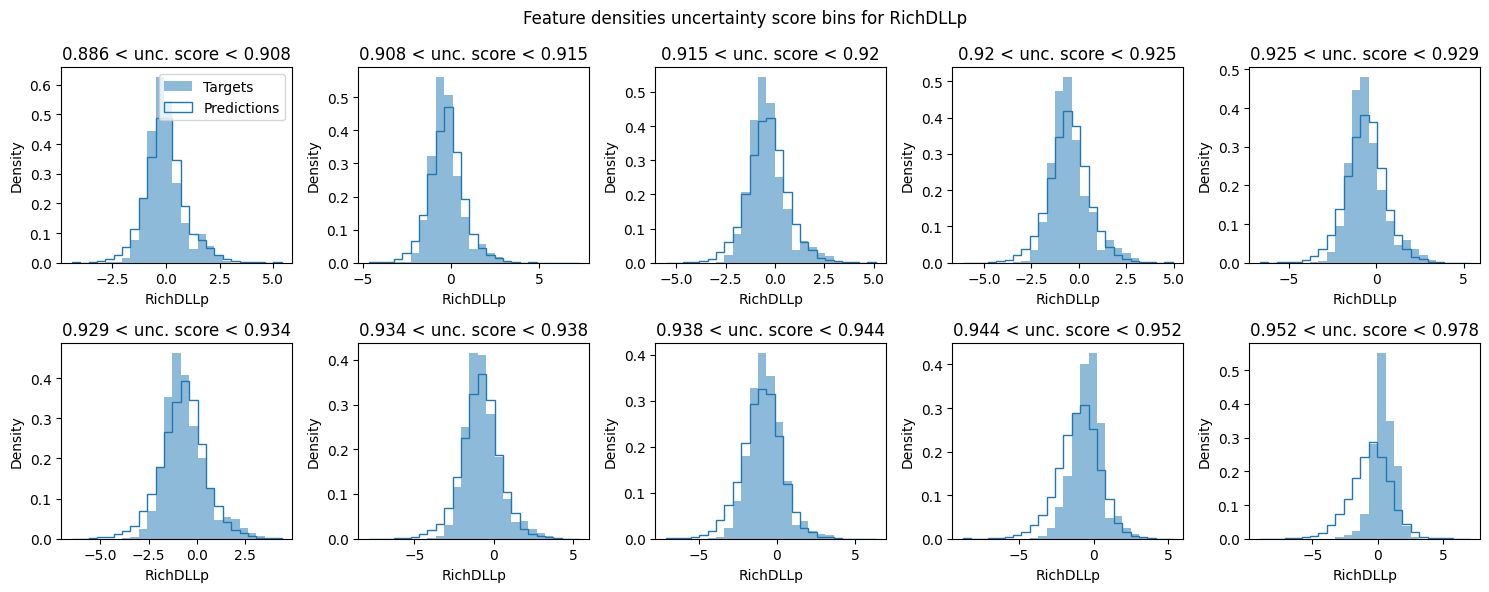

KS Distances:
0.0754, 0.0866, 0.0768, 0.0644, 0.0713, 0.0712, 0.0686, 0.1015, 0.2148, 0.39793979397939794
0.886 < unc. score < 0.908: Number of observations: 10000
0.908 < unc. score < 0.915: Number of observations: 10000
0.915 < unc. score < 0.92: Number of observations: 10000
0.92 < unc. score < 0.925: Number of observations: 10000
0.925 < unc. score < 0.929: Number of observations: 10000
0.929 < unc. score < 0.934: Number of observations: 10000
0.934 < unc. score < 0.938: Number of observations: 10000
0.938 < unc. score < 0.944: Number of observations: 10000
0.944 < unc. score < 0.952: Number of observations: 10000
0.952 < unc. score < 0.978: Number of observations: 9999


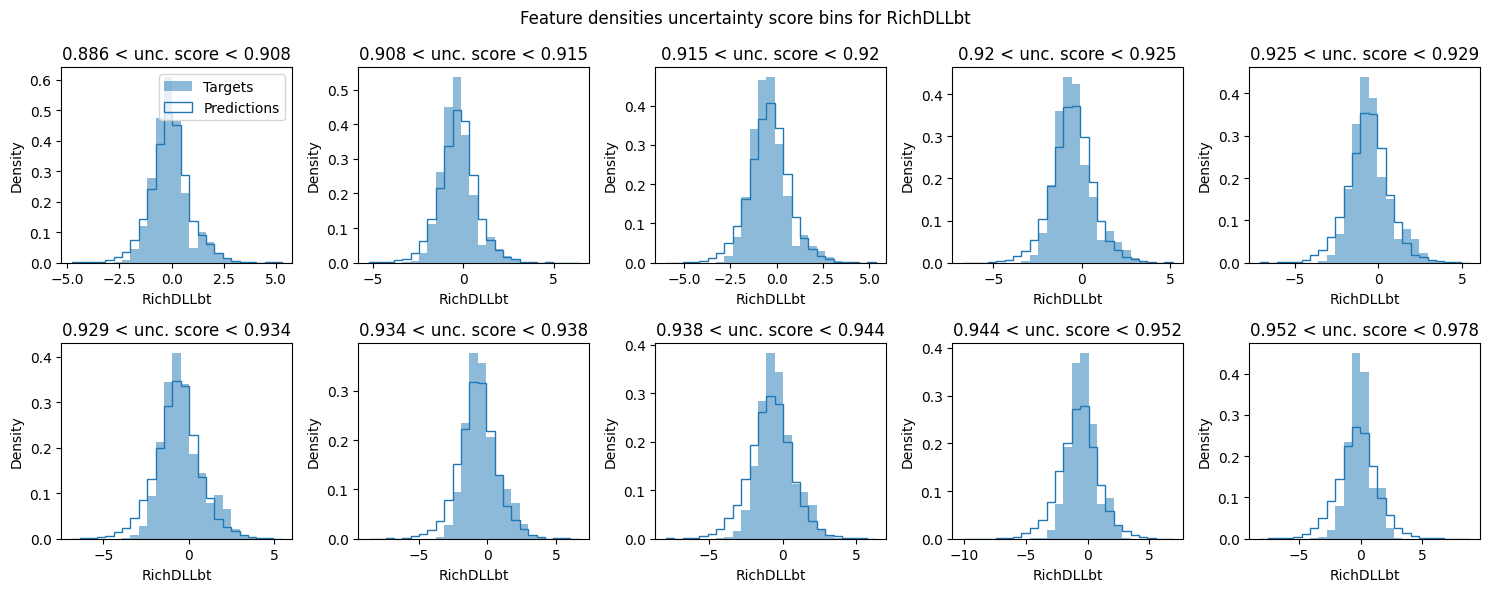

KS Distances:
0.0697, 0.0772, 0.0668, 0.0592, 0.0809, 0.0946, 0.1101, 0.1381, 0.1563, 0.16591659165916592


In [50]:
all_fd_bin_edges, all_fd_js_distances = [], []

# metric = 'JS'
metric = 'KS'

for i in range(5):
  fd_bin_edges, fd_js_distances = estimate_distances_and_plot_uncertainty_bins(
      y_sample, t_generated, fd_uncertainty_normalized, 'Feature densities', 'quantiles', particle_index = i, metric=metric)

  all_fd_bin_edges += [fd_bin_edges]
  all_fd_js_distances += [fd_js_distances]

Correlation coefficient for RichDLLe: 0.9497011603877726
Correlation coefficient for RichDLLK: 0.7813956055036637
Correlation coefficient for RichDLLmu: 0.9293063520747746
Correlation coefficient for RichDLLp: 0.759126773526863
Correlation coefficient for RichDLLbt: 0.8874917420284555


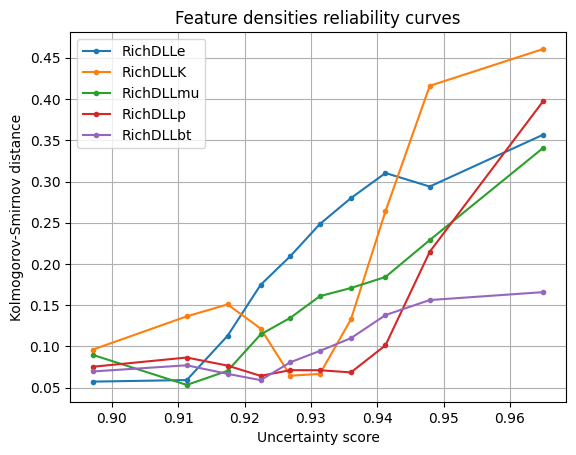

In [55]:
plot_all_distances(all_fd_bin_edges, all_fd_js_distances, 'Feature densities', metric=metric)

## Experiment 30x30

Load Results

In [ ]:
!unzip -qq '/content/drive/MyDrive/cern/data/results/30x30/pion_uncertainty_30x30_reps.zip'
!unzip -qq '/content/drive/MyDrive/cern/data/results/30x30/pion_sample_30x30.zip'

In [ ]:
y_sample = np.load('/content/results/pion_y_real.npy')
x_sample = np.load('/content/results/pion_x_real.npy')

y_sample_orig = np.load('/content/results/pion_y_real_orig.npy')
x_sample_orig = np.load('/content/results/pion_x_real_orig.npy')



t_generated = np.load('/content/results/t_generated.npy')

fd_uncertainty_normalized = np.load('/content/pion_fd_uncertainties_30_times.npy')
mcd_uncertainty = np.load('/content/pion_mcd_uncertainty_30_reps.npy')

fd_uncertainty_normalized = tf.reduce_mean(fd_uncertainty_normalized, axis=0)
mcd_uncertainty = tf.reduce_mean(mcd_uncertainty, axis=0)


fd_uncertainty_normalized.shape, mcd_uncertainty.shape

### FD using JS

In [ ]:
all_fd_bin_edges, all_fd_js_distances = [], []

metric = 'JS'
#metric = 'KS'

for i in range(5):
  fd_bin_edges, fd_js_distances = estimate_distances_and_plot_uncertainty_bins(
      y_sample, t_generated, fd_uncertainty_normalized, 'Feature densities', 'quantiles', particle_index = i, metric=metric)

  all_fd_bin_edges += [fd_bin_edges]
  all_fd_js_distances += [fd_js_distances]

plot_all_distances(all_fd_bin_edges, all_fd_js_distances, 'Feature densities', metric=metric)

### FD using KS

In [ ]:
all_fd_bin_edges, all_fd_js_distances = [], []

#metric = 'JS'
metric = 'KS'

for i in range(5):
  fd_bin_edges, fd_js_distances = estimate_distances_and_plot_uncertainty_bins(
      y_sample, t_generated, fd_uncertainty_normalized, 'Feature densities', 'quantiles', particle_index = i, metric=metric)

  all_fd_bin_edges += [fd_bin_edges]
  all_fd_js_distances += [fd_js_distances]

plot_all_distances(all_fd_bin_edges, all_fd_js_distances, 'Feature densities', metric=metric)

### MCD using JS

In [ ]:
all_mcd_bin_edges, all_mcd_js_distances = [], []

metric = 'JS'
#metric = 'KS'

for i in range(5):
  mcd_bin_edges, mcd_js_distances = estimate_distances_and_plot_uncertainty_bins(
      y_sample, t_generated, mcd_uncertainty, uncertainty_type = 'MCD', bin_type='quantiles', particle_index = i, metric=metric)
  all_mcd_bin_edges += [mcd_bin_edges]
  all_mcd_js_distances += [mcd_js_distances]


plot_all_distances(all_mcd_bin_edges, all_mcd_js_distances, 'MCD', metric=metric)

### MCD using KS

In [ ]:
all_mcd_bin_edges, all_mcd_js_distances = [], []

#metric = 'JS'
metric = 'KS'

for i in range(5):
  mcd_bin_edges, mcd_js_distances = estimate_distances_and_plot_uncertainty_bins(
      y_sample, t_generated, mcd_uncertainty, uncertainty_type = 'MCD', bin_type='quantiles', particle_index = i, metric=metric)
  all_mcd_bin_edges += [mcd_bin_edges]
  all_mcd_js_distances += [mcd_js_distances]


plot_all_distances(all_mcd_bin_edges, all_mcd_js_distances, 'MCD', metric=metric)

## Uncertainty heatmaps

### FD heatmaps

In [ ]:
def uncertainty_scatter_plot_fd(x_real, uncertainties):
  momentum = x_real[:, 0]
  eta = x_real[:, 1]

  plt.title('Feature densities heatmap')
  plt.scatter(momentum, eta, .1, uncertainties, cmap='inferno')
  plt.colorbar(label='Uncertainty score')
  plt.xlabel('Momentum')
  plt.ylabel('Eta')
  plt.show()

In [ ]:
uncertainty_scatter_plot_fd(x_sample, fd_uncertainty_normalized)

In [ ]:
def uncertainty_hist2d_fd(x_real, uncertainties, n_bins=100):
  uncertainties = np.array(uncertainties)

  momentum = x_real[:, 0]
  eta = x_real[:, 1]

  momentum_edges, eta_edges = np.histogram2d(momentum, eta, n_bins)[1:]
  momentum_indices = np.digitize(momentum, momentum_edges)
  eta_indices = np.digitize(eta, eta_edges)

  heatmap = []

  for i in range(1, n_bins + 1):
    row = []
    for j in range(1, n_bins + 1):
      row += [uncertainties[(momentum_indices == j) & (eta_indices == i)].mean()]
    heatmap += [row]

  plt.title('Feature densities heatmap')
  plt.imshow(heatmap, 'inferno')
  plt.gca().invert_yaxis()
  plt.colorbar(label='Uncertainty score')
  plt.xlabel('Momentum')
  plt.ylabel('Eta')
  plt.show()

In [ ]:
uncertainty_hist2d_fd(x_sample, fd_uncertainty_normalized)

In [ ]:
from scipy.stats import binned_statistic_2d
import matplotlib as mpl

mpl.rcParams['font.family'] = 'serif'

def uncertainty_binned2d_fd(x_real, uncertainties, n_bins=5, bin_size=50):

    if not isinstance(x_real, np.ndarray):
        x_real = x_real.numpy()

    if not isinstance(uncertainties, np.ndarray):
        uncertainties = uncertainties.numpy()

    momentum = x_real[:, 0]
    eta = x_real[:, 1]
    num_tracks = x_real[:, 2]

    bin_edges = np.quantile(num_tracks, np.linspace(0, 1, n_bins + 1))
    bin_indices = np.digitize(num_tracks, bin_edges, right=True)

    fig, axes = plt.subplots(1, n_bins, figsize=(16, 3))
    plt.subplots_adjust(hspace=0.3, wspace=0.3)

    for i in range(n_bins):
        mask = bin_indices == (i + 1)

        x_data = momentum[mask]
        y_data = eta[mask]
        u_data = uncertainties[mask]

        x_bins = np.logspace(np.log10(x_data.min()), np.log10(x_data.max()), bin_size)
        y_bins = np.linspace(y_data.min(), y_data.max(), bin_size)

        bin_means, x_edges, y_edges, _ = binned_statistic_2d(
            x_data, y_data, u_data, statistic='mean', bins=[x_bins, y_bins]
        )

        ax = axes[i]
        ax.set_title(f'Tracks [{bin_edges[i]:.2f}, {bin_edges[i + 1]:.2f}]')
        mesh = ax.pcolormesh(x_edges, y_edges, bin_means.T, cmap='inferno', shading='auto')
        ax.set_xscale('log')
        ax.set_xlabel('Momentum')
        ax.set_ylabel('Eta')

    fig.colorbar(mesh, ax=axes, label='Uncertainty score', orientation='vertical', fraction=0.02, pad=0.01)
    plt.suptitle('Features Densities Heatmap for Different Track Ranges', y=1.05)
    plt.savefig("Features_densities_heatmap_for_different_track_ranges.svg", format="svg")
    plt.show()


In [ ]:
uncertainty_binned2d_fd(x_sample_orig, fd_uncertainty_normalized)

### MCD heatmaps

In [ ]:
def uncertainty_scatter_plot_mcd(x_real, uncertainties):
  momentum = x_real[:, 0]
  eta = x_real[:, 1]

  fig, axes = plt.subplots(2, 3, figsize=(11, 6))

  for i, ax in enumerate(axes.flatten()[:-1]):
    ax.set_title(DLL_COLUMNS[i])
    scatter = ax.scatter(momentum, eta, .1, uncertainties[:, i], cmap='inferno')
    plt.colorbar(scatter, label='Uncertainty score')
    ax.set_xlabel('Momentum')
    ax.set_ylabel('Eta')

  plt.suptitle('MCD heatmaps')
  axes[-1, -1].axis(False)
  plt.tight_layout()
  plt.show()

In [ ]:
uncertainty_scatter_plot_mcd(x_sample, mcd_final_uncertainty)

In [ ]:
def uncertainty_hist2d_mcd(x_real, uncertainties, n_bins=100):
  uncertainties = np.array(uncertainties)

  momentum = x_real[:, 0]
  eta = x_real[:, 1]

  fig, axes = plt.subplots(2, 3, figsize=(11, 6))

  for ax_index, ax in enumerate(axes.flatten()[:-1]):
    momentum_edges, eta_edges = np.histogram2d(momentum, eta, n_bins)[1:]
    momentum_indices = np.digitize(momentum, momentum_edges)
    eta_indices = np.digitize(eta, eta_edges)

    heatmap = []

    for i in range(1, n_bins + 1):
      row = []
      for j in range(1, n_bins + 1):
        row += [uncertainties[(momentum_indices == j) & (eta_indices == i), ax_index].mean()]
      heatmap += [row]

    ax.set_title(DLL_COLUMNS[ax_index])
    image = ax.imshow(heatmap, 'inferno')
    ax.invert_yaxis()
    plt.colorbar(image, label='Uncertainty score')
    ax.set_xlabel('Momentum')
    ax.set_ylabel('Eta')

  plt.suptitle('MCD heatmaps')
  axes[-1, -1].axis(False)
  plt.tight_layout()
  plt.show()

In [ ]:
uncertainty_hist2d_mcd(x_sample, mcd_final_uncertainty)

In [ ]:
from scipy.stats import binned_statistic_2d
import matplotlib as mpl

mpl.rcParams['font.family'] = 'serif'

def uncertainty_binned2d_mcd(x_real, uncertainties, particle_idx, n_bins=5, dll_columns=DLL_COLUMNS, bin_size=50):

    if not isinstance(x_real, np.ndarray):
      x_real = x_real.numpy()

    if not isinstance(uncertainties, np.ndarray):
      uncertainties = uncertainties.numpy()

    momentum = x_real[:, 0]
    eta = x_real[:, 1]
    num_tracks = x_real[:, 2]

    bin_edges = np.quantile(num_tracks, np.linspace(0, 1, n_bins + 1))
    bin_indices = np.digitize(num_tracks, bin_edges, right=True)

    fig, axes = plt.subplots(1, 5, figsize=(16, 3))
    plt.subplots_adjust(hspace=0.3, wspace=0.3)

    for i in range(n_bins):
        ax = axes[i]

        bin_mask = bin_indices == (i + 1)
        x_data = momentum[bin_mask]
        y_data = eta[bin_mask]
        u_data = uncertainties[bin_mask, particle_idx]

        x_bins = np.logspace(np.log10(x_data.min()), np.log10(x_data.max()), bin_size)
        y_bins = np.linspace(y_data.min(), y_data.max(), bin_size)

        bin_means, x_edges, y_edges, _ = binned_statistic_2d(
            x_data, y_data, u_data, statistic='mean', bins=[x_bins, y_bins]
        )

        ax = axes[i]
        ax.set_title(f'Tracks [{bin_edges[i]:.2f}, {bin_edges[i + 1]:.2f}]')
        mesh = ax.pcolormesh(x_edges, y_edges, bin_means.T, cmap='inferno', shading='auto')
        ax.set_xscale('log')
        ax.set_xlabel('Momentum(MeV/c)')
        ax.set_ylabel('Eta')

        plt.suptitle(f'MCD Heatmap for Different Track Ranges for particle {DLL_COLUMNS[particle_idx]}', y=1.05)

    fig.colorbar(mesh, ax=axes, label='Uncertainty score', orientation='vertical', fraction=0.02, pad=0.01)
    plt.savefig(f'MCD_Heatmap_for_Different_Track_Ranges_for_particle_{DLL_COLUMNS[particle_idx]}.svg', format="svg")
    plt.show()

In [ ]:
for i in range(5):
  uncertainty_scores = mcd_uncertainty[:, i]
  bin_edges = np.quantile(uncertainty_scores, np.linspace(0, 1, 11))
  limit = bin_edges[9]

  reduced_x_sample = x_sample_orig[uncertainty_scores < limit]
  reduced_uncertainty = mcd_uncertainty[uncertainty_scores < limit]
  #print(reduced_x_sample.shape)
  #print(reduced_uncertainty.shape)
  uncertainty_binned2d_mcd(reduced_x_sample, reduced_uncertainty, i)

# Efficiency plots

In [ ]:
def select_threshold(feature, quantile=0.1):
    return np.quantile(feature, quantile)

def efficiency_bins(targets, threshold, particle_index):
    def compute_efficiency(y):
        return (y > threshold).mean()

    def compute_error(y):
        err = (y < threshold).sum() * (y > threshold).sum() / y.size**3
        return np.sqrt(err)

    efficiencies = []
    errors = []

    for target in targets:
        eff = compute_efficiency(target[:, particle_index])
        err = compute_error(target[:, particle_index])

        efficiencies.append(eff)
        errors.append(err)

    return efficiencies, errors

def compute_bin_indices(data, n_bins):
  bin_edges = np.linspace(data.min(), data.max(), n_bins + 1)
  indices = np.digitize(data, bin_edges)
  return indices

def plot_efficiencies(y_sample, t_generated, uncertainties, quantiles, n_bins=10, dll_columns=DLL_COLUMNS):
  y_sample = np.array(y_sample)
  t_generated = np.array(t_generated)
  uncertainties = np.array(uncertainties)

  fig, axes = plt.subplots(2, 3, figsize=(9, 6))

  indices = compute_bin_indices(uncertainties, n_bins)

  bins_targets = [t_generated[indices == i] for i in range(1, n_bins + 1)]
  bins_likelihoods = [uncertainties[indices == i].mean() for i in range(1, n_bins + 1)]

  for idx, ax in zip(range(5), axes.flatten()):
      for quantile in quantiles:
          threshold = select_threshold(y_sample[:, idx], quantile)
          eff, err = efficiency_bins(bins_targets, threshold, idx)

          plot = ax.plot(bins_likelihoods, eff, '.-', label=f'Quantile = {int(quantile * 100)}%')
          ax.errorbar(bins_likelihoods, eff, err, color=plot[0].get_color())

      ax.set_title(dll_columns[idx])
      ax.set_axisbelow(True)
      ax.grid()
      ax.set_xlabel("Bin likelihood")
      ax.set_ylabel("Efficiency")

  axes[-1, -1].axis(False)
  handles, labels = ax.get_legend_handles_labels()
  plt.legend(handles, labels, loc='upper left')

  plt.tight_layout()
  plt.show()

In [ ]:
plot_efficiencies(y_sample, t_generated, fd_uncertainty_normalized, [.1, .2, .3])

##Plot Efficiencies by particle

In [ ]:
def plot_efficiencies_by_particle(y_sample, t_generated, uncertainties, quantiles, uncertainty_type="MCD", particle_idx=0, n_bins=10, dll_columns=DLL_COLUMNS):
    y_sample = np.array(y_sample)
    t_generated = np.array(t_generated)
    uncertainties = np.array(uncertainties)

    fig, axes = plt.subplots(2, 3, figsize=(9, 6))

    colors = plt.colormaps['tab10']

    if uncertainty_type == "MCD":
        uncertainties_column = uncertainties[:, particle_idx]
    else:
        uncertainties_column = uncertainties


    bin_edges = np.quantile(uncertainties_column, np.linspace(0, 1, n_bins + 1))
    indices = np.digitize(uncertainties_column, bin_edges, right=True)

    bins_targets = [t_generated[indices == i] for i in range(1, n_bins + 1)]
    bins_real = [y_sample[indices == i] for i in range(1, n_bins + 1)]
    bins_likelihoods = [uncertainties_column[indices == i].mean() for i in range(1, n_bins + 1)]

    for idx, ax in zip(range(len(quantiles)), axes.flatten()):
        quantile = quantiles[idx]
        threshold = select_threshold(y_sample[:, particle_idx], quantile)

        eff_gen, err_gen = efficiency_bins(bins_targets, threshold, particle_idx)
        eff_real, err_real = efficiency_bins(bins_real, threshold, particle_idx)



        ax.plot(bins_likelihoods, eff_gen, '.-', color=colors(0), label='Generated')

        ax.fill_between(bins_likelihoods, np.array(eff_gen) - np.array(err_gen),
                        np.array(eff_gen) + np.array(err_gen), color=colors(0), alpha=0.3)

        ax.plot(bins_likelihoods, eff_real, '.-', color=colors(20), label='Real')

        ax.fill_between(bins_likelihoods, np.array(eff_real) - np.array(err_real),
                        np.array(eff_real) + np.array(err_real), color=colors(20), alpha=0.3)

        ax.set_title(f'Threshold {int(quantile * 100)}%')
        ax.set_axisbelow(True)
        ax.grid()
        ax.set_xlabel("Uncertainty Score")
        ax.set_ylabel("Efficiency")
        ax.set_ylim(0, 1.10)

    axes[-1, -1].axis(False)

    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper left', bbox_to_anchor=(0.73, 0.45), fontsize='small')

    plt.suptitle(f'{uncertainty_type} efficiencies plot for {dll_columns[particle_idx]}')

    plt.tight_layout()
    plt.show()

### Plot FD efficiencies

In [ ]:
for i in range(5):
  plot_efficiencies_by_particle(y_sample, t_generated, fd_uncertainty_normalized, [.1, .25, .5, .75, .9], "Feature densities", i)

### Plot MCD efficiencies

In [ ]:
for i in range(5):
  plot_efficiencies_by_particle(y_sample, t_generated, mcd_final_uncertainty, [.1, .25, .5, .75, .9], "MCD", i)

# Archived

#### FD with integration method


In [ ]:
fd_uncertainty_integration, _ = fd_evaluate_model(model, x_sample, known_embeddings=train_embeddings, n_fit_samples=100,
                                                  likelihood_method='integration')

print('Feature Densities using INTEGRATION uncertainty score for x_sample:')
fd_uncertainty_integration

In [ ]:
# Save FD uncertainties with integration
np.save(output_dir + f'{PARTICLE}_fd_uncertainty_integration.npy', fd_uncertainty_integration)

In [ ]:
all_fd_bin_edges, all_fd_js_distances = [], []

for i in range(5):
  fd_bin_edges, fd_js_distances = estimate_distances_and_plot_uncertainty_bins(
      y_sample, t_generated, fd_uncertainty_integration, 'Feature densities', particle_index = i, n_rows = 3, n_cols = 3)

  all_fd_bin_edges += [fd_bin_edges]
  all_fd_js_distances += [fd_js_distances]

In [ ]:
plot_all_distances(all_fd_bin_edges, all_fd_js_distances, 'Feature densities')

#### MCD / Linear bins

In [ ]:
all_mcd_bin_edges, all_mcd_js_distances = [], []


for i in range(5):
  mcd_bin_edges, mcd_js_distances = estimate_distances_and_plot_uncertainty_bins(
      y_sample, t_generated, mcd_uncertainty, uncertainty_type = 'MCD', particle_index = i)
  all_mcd_bin_edges += [mcd_bin_edges]
  all_mcd_js_distances += [mcd_js_distances]

In [ ]:
plot_all_distances(all_mcd_bin_edges, all_mcd_js_distances, 'MCD')

#### FD / Linear bins

In [ ]:
all_fd_bin_edges, all_fd_js_distances = [], []

for i in range(5):
  fd_bin_edges, fd_js_distances = estimate_distances_and_plot_uncertainty_bins(
      y_sample, t_generated, fd_uncertainty_normalized, 'Feature densities', particle_index = i)

  all_fd_bin_edges += [fd_bin_edges]
  all_fd_js_distances += [fd_js_distances]

In [ ]:
plot_all_distances(all_fd_bin_edges, all_fd_js_distances, 'Feature densities')